# Instalações de Bibliotecas

In [1]:
from pathlib import Path 
#IBOVESPA (^BVSP)
#NASDAQ Composite (^IXIC)
#Dow Jones Industrial Average (^DJI)
#CAC 40 (^FCHI)
#FTSE 100 (^FTSE) 
#DAX PERFORMANCE-INDEX (^GDAXI)
Indices = ["BVSP", "IXIC", "DJI", "FCHI", "FTSE", "GDAXI"]
index_train = "2000-01-01", "2016-12-31"
index_valid = "2017-01-01", "2018-12-31"
index_test = "2019-01-01", "2020-12-31"
index_novidades = "2021-01-01", "2021-12-31"

In [2]:
from pathlib import Path 
from configparser import ConfigParser
import json

config = ConfigParser()
config.read("config.ini")

print(config.sections())
config["Train"]["end"]
for e in json.loads(config["Indices"]["Indices"]):
    print(e)


['Train', 'Valid', 'Test', 'News', 'Indices']
BVSP
IXIC
DJI
FCHI
FTSE
GDAXI


# Analise de séries temporais.

## Data

In [70]:
import pandas as pd
import yfinance as yf
from pathlib import Path  
import matplotlib.pyplot as plt

def download_data(TS, start, end, interval = "1d", period = None,):  
    data = yf.download(  # or pdr.get_data_yahoo(...
            # tickers list or string as well
            tickers = TS,
            # use "period" instead of start/end
            # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
            # (optional, default is '1mo')
            period = period,  
            start = start,
            end=end,         
            
            # fetch data by interval (including intraday if period < 60 days)
            # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
            # (optional, default is '1d')
            interval = interval,

            # group by ticker (to access via data['SPY'])
            # (optional, default is 'column')
            group_by = 'ticker',

            # adjust all OHLC automatically
            # (optional, default is False)
            auto_adjust = True,

            # download pre/post regular market hours data
            # (optional, default is False)
            prepost = False,

            # use threads for mass downloading? (True/False/Integer)
            # (optional, default is True)
            threads = True,

            # proxy URL scheme use use when downloading?
            # (optional, default is None)
            proxy = None
        )
    return data['Close'] 

def import_data(Indices,
            start="2000-01-01",
            end="2021-12-31"):
    
    for e in Indices:
        timeseries= download_data(TS=(str("^")+e), start=start,end=end)
        
        # save to file
        filepath_csv = Path(str(r"data\raw\^")+str(e)+str('.csv'))
        filepath_csv.parent.mkdir(parents=True, exist_ok=True)          
        timeseries.to_csv(filepath_csv)   
        
        filepath_png = Path(str(r"data\raw\^")+str(e)+str('.png'))        
        filepath_png.parent.mkdir(parents=True, exist_ok=True) 
        fig = plt.figure(figsize=(25,10))
        title_acf = "Raw " + str(e)
        timeseries_plot = timeseries.plot(title=title_acf, fig=fig)
        fig.figure.savefig(filepath_png)        
    return "Done importing"    

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


'Done importing'

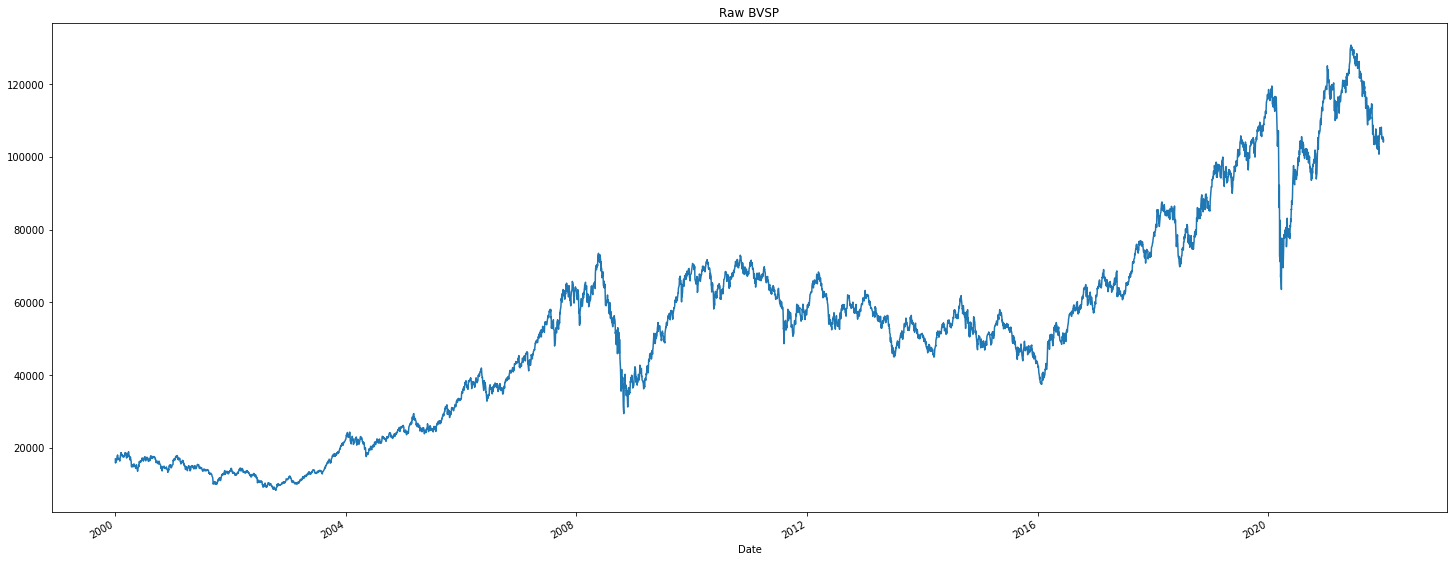

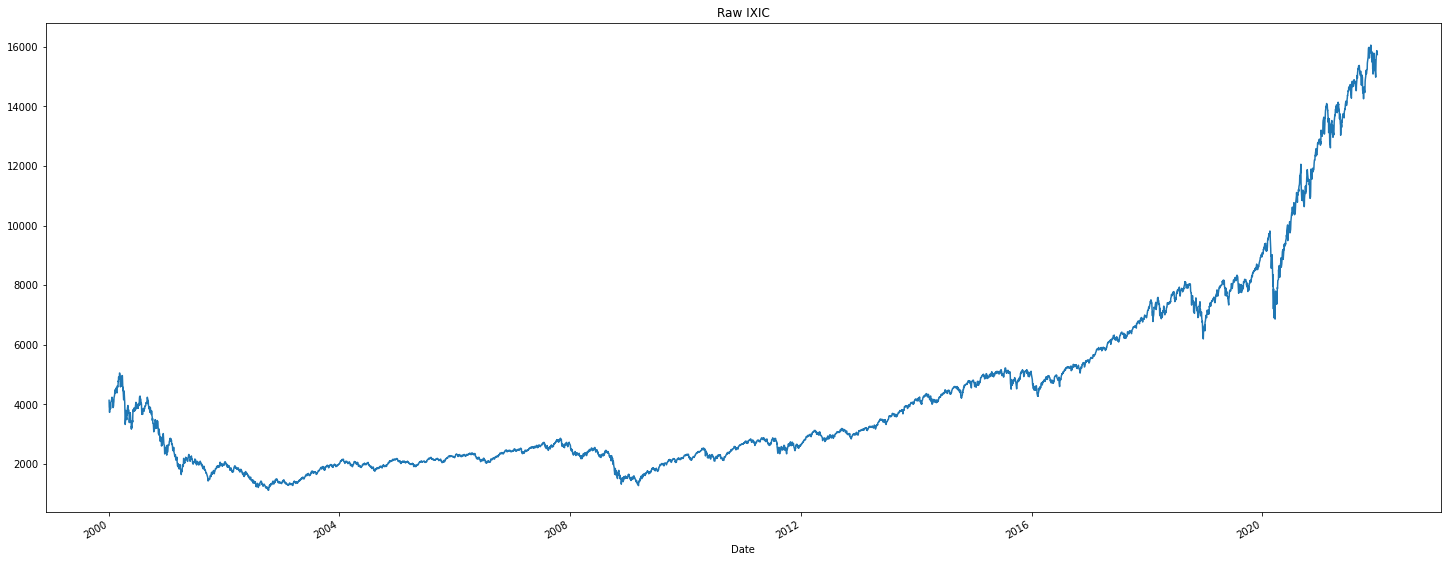

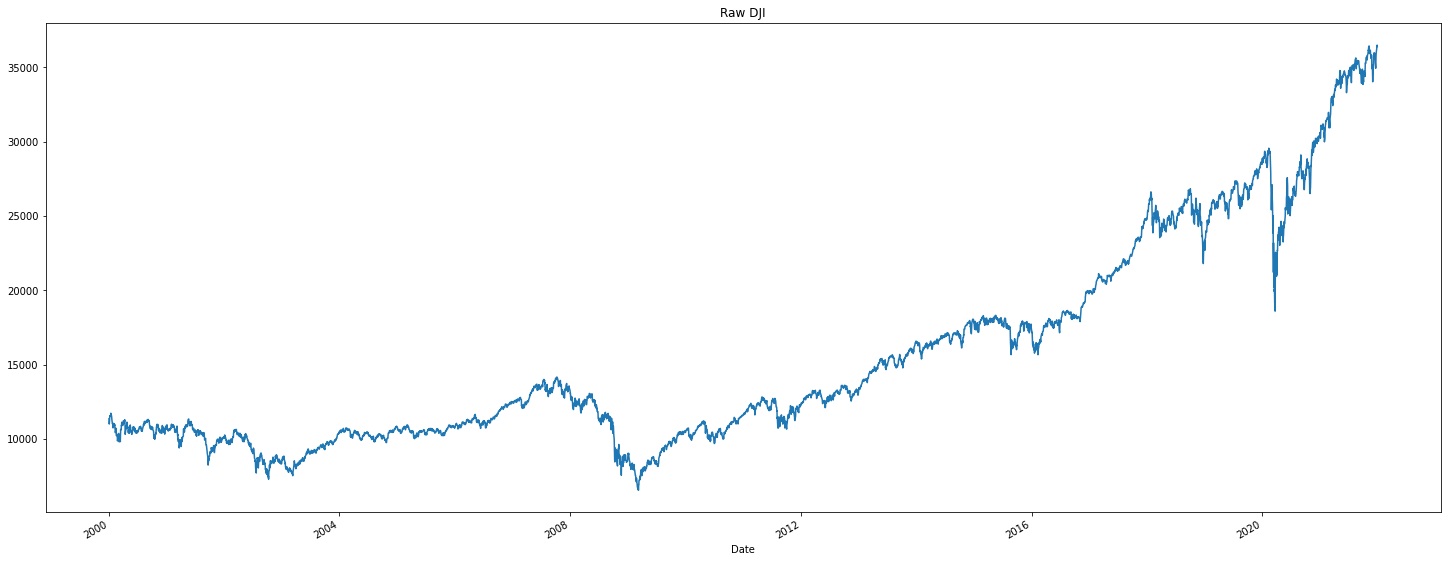

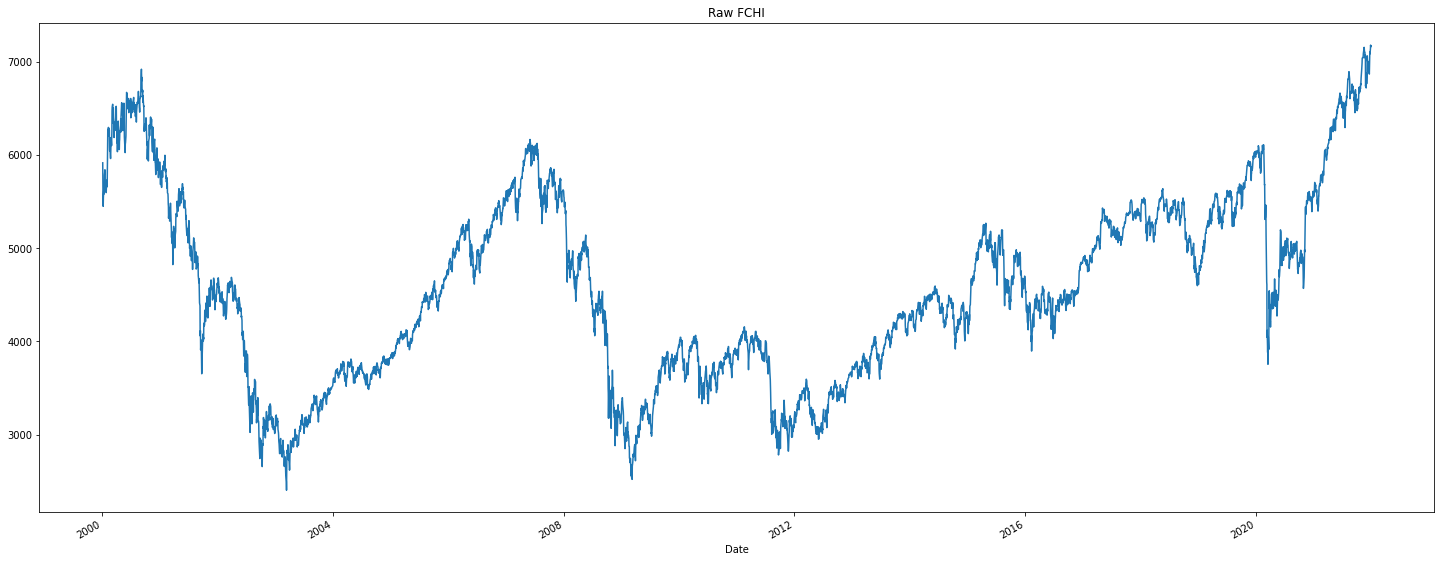

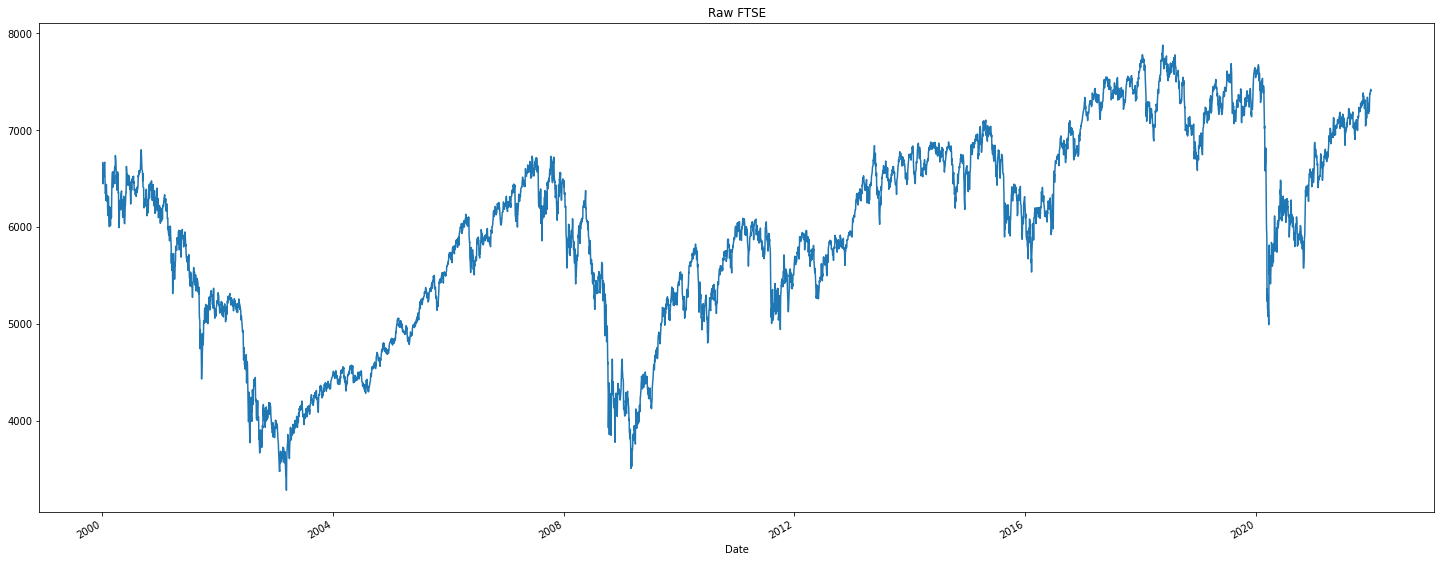

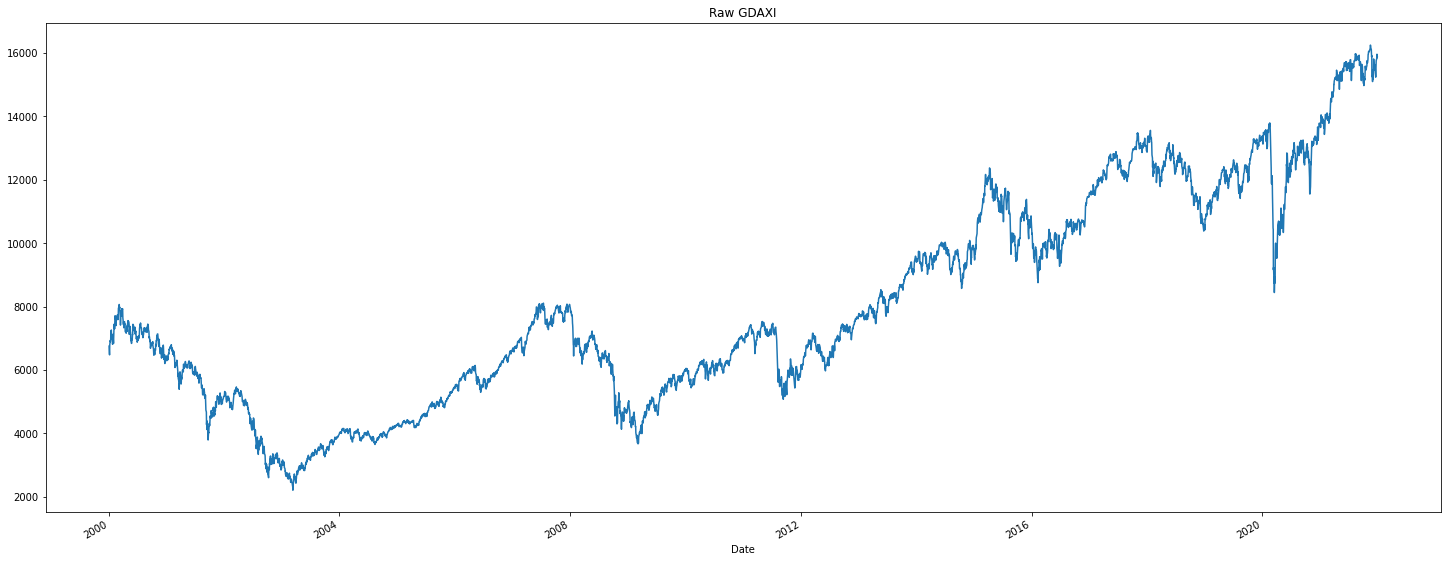

In [71]:
import_data(Indices,start="2000-01-01",end="2021-12-31")

## Normalização

'Normalization completed'

<Figure size 1800x720 with 0 Axes>

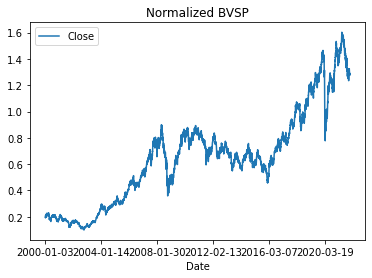

<Figure size 1800x720 with 0 Axes>

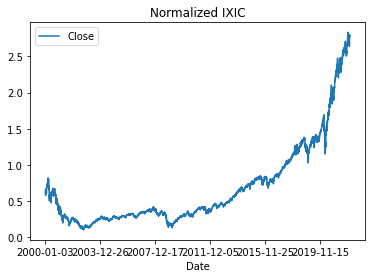

<Figure size 1800x720 with 0 Axes>

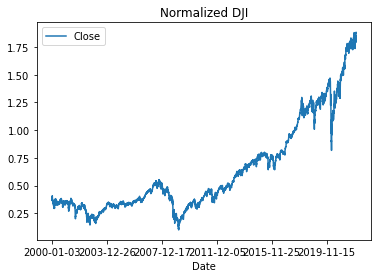

<Figure size 1800x720 with 0 Axes>

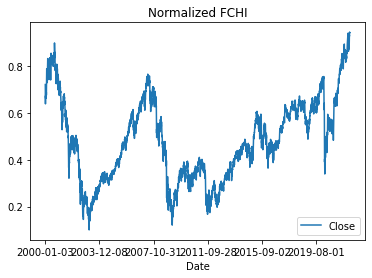

<Figure size 1800x720 with 0 Axes>

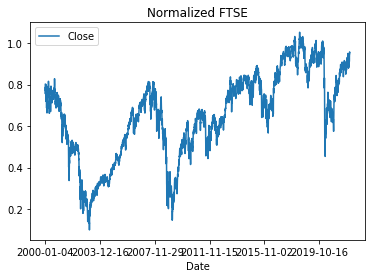

<Figure size 1800x720 with 0 Axes>

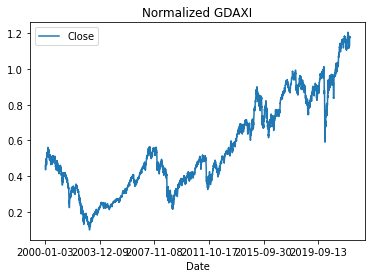

In [9]:
import pandas as pd
class MinMax:
    #The above code is creating a class called MinMaxScaler. The class has two functions: transform and inverse. 
    # The transform function takes in a data_transform and returns a transformed data_transform. 
    # The inverse function takes in a data_inverse and returns an inverse_transform.    
    def __init__(self, data_train, a, b): # a and b are the min and max values of the data_train   
        self.a = a
        self.b = b
        self.data_train = data_train
        self.min = self.data_train.min()
        self.max = self.data_train.max()    
        self.range = self.max - self.min                 

    def transform(self, data_transform): # data_transform is the data that we want to transform
        self.data_transform = data_transform
        self.transform = self.a + (self.data_transform - self.min)*(self.b-self.a) / self.range
        return self.transform
    
    def inverse(self, data_inverse):
        self.data_inverse = data_inverse
        self.inverse_transform = (self.data_inverse - self.a) * self.range / (self.b - self.a) + self.min
        return self.inverse_transform    

#Normalizing the data.
def normalized(Indices, index_train , a, b):   
    for e in Indices:        
        filepath = Path(str(r"data\raw\^")+str(e)+str('.csv'))
        data_train = pd.read_csv(filepath,index_col='Date')[index_train[0]:index_train[1]]
        data = pd.read_csv(filepath,index_col='Date')
        normalized = MinMax(data_train, 0.1, 0.9).transform(data)
             
        # save to file
        filepath_normalized = Path(str(r"data\normalized\^")+str(e)+str('.csv'))
        filepath_normalized.parent.mkdir(parents=True, exist_ok=True)          
        normalized.to_csv(filepath_normalized) 
        
        filepath_png = Path(str(r"data\normalized\^")+str(e)+str('.png'))        
        filepath_png.parent.mkdir(parents=True, exist_ok=True) 
        fig = plt.figure(figsize=(25,10))
        title_acf = "Normalized " + str(e)
        normalized = normalized.plot(title=title_acf, fig=fig)
        normalized.figure.savefig(filepath_png)                   
    return "Normalization completed"

normalized(Indices, index_train, a=0.1, b=0.9)

## Estatisticas

In [73]:
import statsmodels.api as sm
def acf_pacf(df):
    acf_values=sm.tsa.stattools.acf(df, nlags=(len(df)-1),fft=True)
    pacf=sm.tsa.stattools.pacf(df,method='ols')
    fac_min, fac_max, pacf = np.where(acf_values<=1/np.e)[0][0], np.where(acf_values<=0)[0][0], np.where(pacf<=(1-pacf[np.where(pacf<0)[0][0]-1]))[0][0]
    return pacf, fac_min, fac_max 

In [74]:
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew
from pmdarima.arima.utils import ndiffs

def estatisticas(index_train):
    estatisticas = []
    for e in (Indices):      
        timeseries = pd.read_csv(r"data\raw\^"+str(e) +str(".csv"),index_col='Date')[index_train[0]:index_train[1]]["Close"]        
        timeseriesnormal = pd.read_csv(r"data\normalized\^"+str(e) +str(".csv"),index_col='Date')[index_train[0]:index_train[1]] ["Close"] 

        estatisticas.append([timeseries.min(), 
                     timeseries.max(),
                     len(timeseriesnormal),
                     timeseriesnormal.min(), 
                     timeseriesnormal.max(),
                     timeseriesnormal.mean(),
                     timeseriesnormal.var(),
                     kurtosis(timeseriesnormal),
                     skew(timeseriesnormal),
                     acf_pacf(timeseriesnormal)[0],
                     acf_pacf(timeseriesnormal)[1],
                     acf_pacf(timeseriesnormal)[2]])

    estatisticas = pd.DataFrame((estatisticas),
                                columns= ["Min", "Max","length","Min", "Max", "Mean", "Var", "Kurtosis", "Skewness", "PACF", "ACF(1/e)", "ACF(0)"],
                                index= Indices)
    
    # save to file
    filepath = Path(str(r"data\estatisticas.csv"))
    filepath.parent.mkdir(parents=True, exist_ok=True)          
    estatisticas.to_csv(filepath)   
    return "Done Estatisticas"
estatisticas(index_train)

'Done Estatisticas'

In [75]:
pd.read_csv(Path(str(r"data//estatisticas.csv")), index_col=[0])

Min           Max  length  Min.1  Max.1      Mean       Var  \
BVSP   8371.000000  73517.000000    4207    0.1    0.9  0.504361  0.056678   
IXIC   1114.109985   5487.439941    4277    0.1    0.9  0.410489  0.041435   
DJI    6547.049805  19974.619141    4277    0.1    0.9  0.437687  0.030740   
FCHI   2403.040039   6922.330078    4342    0.1    0.9  0.433136  0.026092   
FTSE   3287.000000   7142.799805    4295    0.1    0.9  0.584945  0.032892   
GDAXI  2202.959961  12374.730469    4319    0.1    0.9  0.444377  0.029870   

       Kurtosis  Skewness  PACF  ACF(1/e)  ACF(0)  
BVSP  -1.374994 -0.276032     2       826    1235  
IXIC  -0.479209  0.837432     2       525    1091  
DJI   -0.453871  0.754726     2       574    1014  
FCHI  -0.288203  0.565097     2       262     417  
FTSE  -0.763436 -0.476540     2       345     582  
GDAXI -0.469894  0.436056     2       528    1035

## Graficos 

### ACF

In [76]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

class graphs: #save the graphs and the plots
    def __init__(self, index_name):
        self.index_name = index_name
        self.data_train = pd.read_csv(r"data\normalized\^"+str(e) +str(".csv"),index_col='Date')[index_train[0]:index_train[1]][2:]
        self.length = len(self.data_train)  
                
    def acf(self):    
        self.title = "Autocorrelation " + str(self.index_name)          
        self.fig = plt.figure(figsize=(35,12))
        #self.ax1 = self.fig.add_subplot(223)   
        self.filepath_png = Path(str(r"data\graphs\acf\^")+str(self.index_name)+str('.png'))        
        self.filepath_csv = Path(str(r"data\graphs\acf\^")+str(self.index_name)+str('.csv'))
        self.acf = sm.graphics.tsa.acf(self.data_train, nlags=(self.length -1))   
        self.acf_plot = plot_acf(self.data_train, 
                                                 title=self.title,
                                                 lags=(self.length -1))      
        # save to file       
        filepath.parent.mkdir(parents=True, exist_ok=True)          
        pd.DataFrame({'ACF':self.acf}, index=self.data_train.index).to_csv(self.filepath_csv)       
        self.acf_plot.savefig(self.filepath_png)
        return self.acf   
    
    def pacf(self):    
        self.title = "Autocorrelation Partial " + str(self.index_name)          
        self.fig = plt.figure(figsize=(35,12))
        
        self.filepath_png = Path(str(r"data\graphs\pacf\^{}{}".format(self.index_name,'.png')))     
        self.filepath_csv = Path(str(r"data\graphs\pacf\{}{}".format(self.index_name,'.csv')))  
        self.pacf = sm.graphics.tsa.pacf(self.data_train, 
                                         nlags=(int(self.length/2) -1), 
                                         method='ywm')   
        
        self.pacf_plot = plot_pacf(self.data_train, 
                                   title=self.title,
                                   lags=(int(self.length/2) -1),
                                   method='ywm',
                                   auto_ylims=True)     
        # save to file       
        filepath.parent.mkdir(parents=True, exist_ok=True)          
        pd.DataFrame({'PACF':self.pacf}).to_csv(self.filepath_csv)       
        self.pacf_plot.savefig(self.filepath_png)
        return self.pacf 
    
    def open_acf(self):
        self.filepath_csv = Path(str(r"data\graphs\acf\^")+str(self.index_name)+str('.csv'))
        return pd.read_csv(self.filepath_csv, index_col= 'Date')


NameError: name 'filepath' is not defined

<Figure size 2520x864 with 0 Axes>

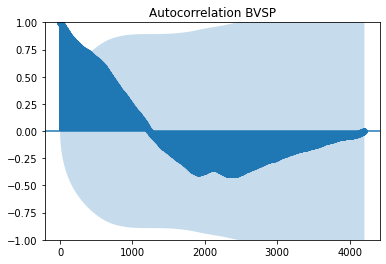

In [77]:
for e in Indices:  
    graphs(e).acf()  

### PACF

In [ ]:
for e in Indices:  
    graphs(e).pacf()  

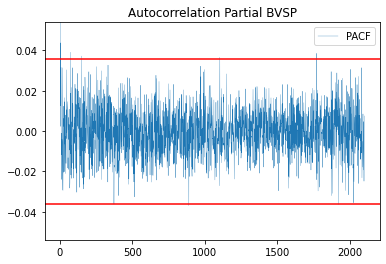

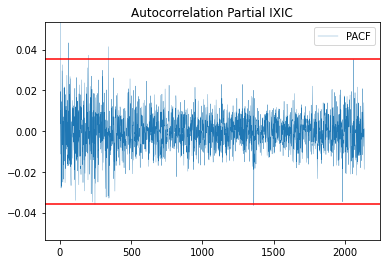

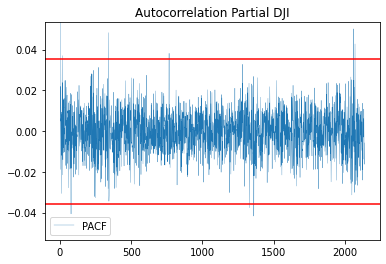

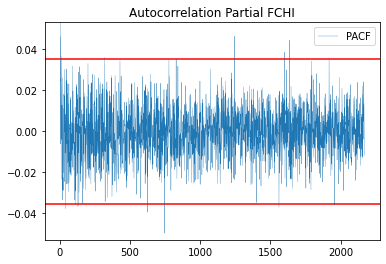

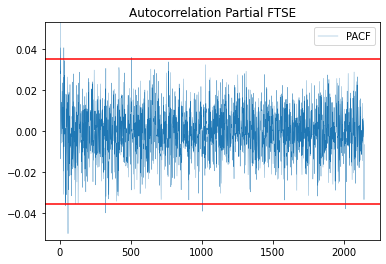

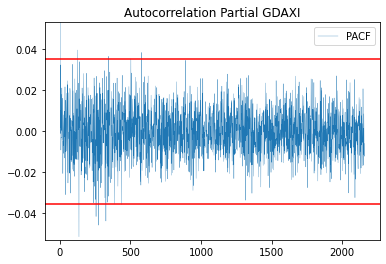

In [ ]:
from scipy.stats import norm

for indice in Indices:
    title = "Autocorrelation Partial " + str(indice)  
    PACF = pd.read_csv(r"data\graphs\pacf\{}{}".format(str(indice),'.csv'))["PACF"]
    Ic = norm.ppf(0.95)/np.sqrt(len(PACF))
    pd.DataFrame(PACF).plot(linewidth=0.3, title = title, ylim=(-Ic*1.5, Ic*1.5))
    plt.axhline(y=Ic, color='r', linestyle='-')
    plt.axhline(y=-Ic, color='r', linestyle='-')

### IMM

In [ ]:
import sys
import time
from pathlib import Path  
from time import sleep
from tqdm import tqdm
from sklearn.feature_selection import mutual_info_regression

def IM_IMM(Indice):
    im = []
    imm = []
    Data = pd.read_csv(r"data\normalized\^{}{}".format(Indice, ".csv"), index_col='Date')[index_train[0]:index_train[1]]
    Data = Data["Close"]
    
    for e in tqdm(range(1, int(len(Data))-4)):
        start = e
        im.append(mutual_info_regression(pd.DataFrame(Data[:-start]),  Data[start:]))
        
    for meanlags in range(1,len(im)):  
        imm.append(np.mean(im[0:meanlags]))
    
    im = pd.DataFrame(im)
    im.plot(title=Indice, xlabel='Retardos Temporais',label='IM', ylabel='Informação Mutua', linewidth=0.7, ylim= (-.1, 2)) 
    
    imm = pd.DataFrame(imm)
    imm.plot(title=Indice, xlabel='Retardos Temporais',label='IMM', ylabel='Informação Mutua Média', linewidth=0.7) 
    
    filepath_csv = Path(r"data\graphs\im\^{}{}".format(Indice, '.csv'))
    filepath_csv.parent.mkdir(parents=True, exist_ok=True)                 
    im.to_csv(filepath_csv)      
    
    filepath_csv = Path(r"data\graphs\imm\^{}{}".format(Indice, '.csv'))
    filepath_csv.parent.mkdir(parents=True, exist_ok=True)                 
    imm.to_csv(filepath_csv)  
    return imm

100%|██████████| 4314/4314 [00:49<00:00, 87.65it/s] 


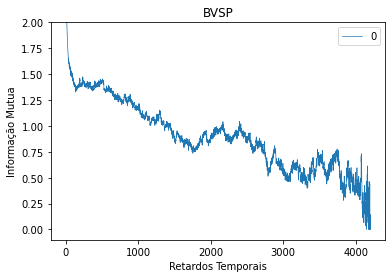

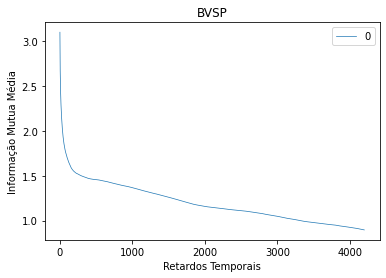

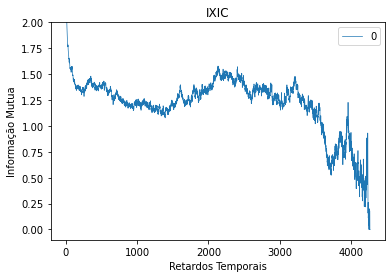

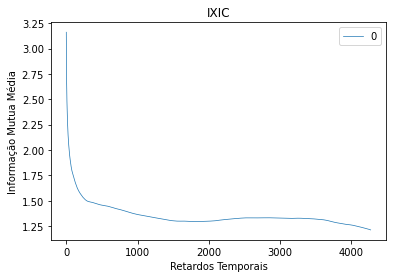

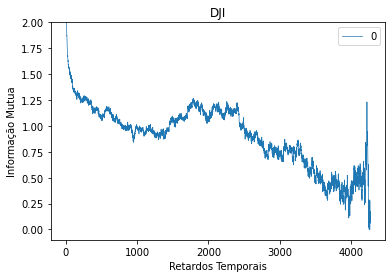

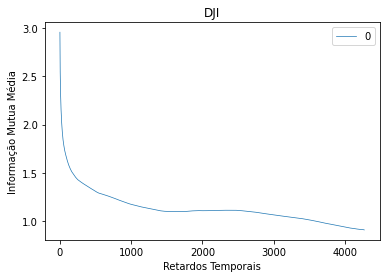

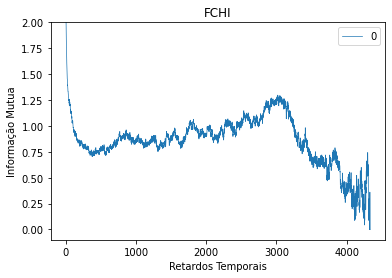

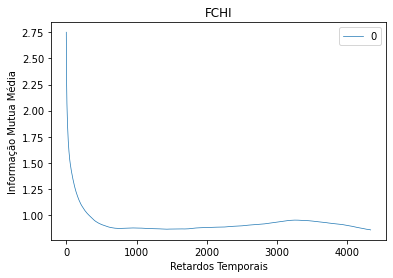

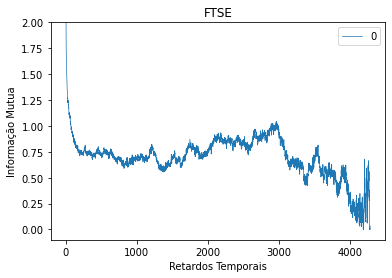

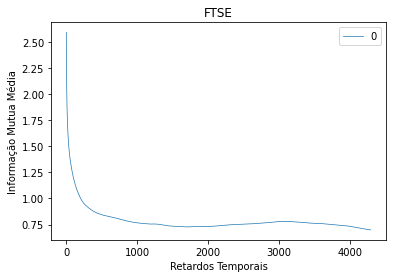

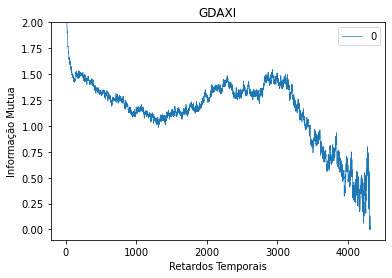

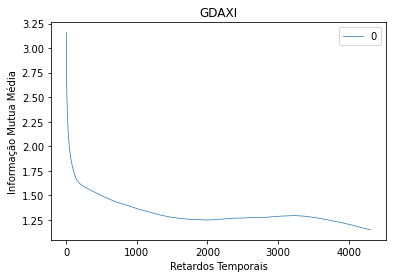

In [ ]:
for Indice in Indices:
    IM_IMM(Indice)

In [ ]:
def IMM_X_Y(Indices="BVSP", delay=1, window_size=5, year=None):
    if year == None:       
        index_train = "2000-01-01", "2016-12-31"
        
    function = WindowGenerator(Indices, delay).window(window_size, year)
    
    train = len(function[0][index_train[0]:index_train[1]])

    x_train = function[0][:train] #Ajuste de Fase    
    y_train = function[1][:train] #Ajuste de Fase

    return (x_train,y_train)

In [ ]:
train = IMM_X_Y(Indices="BVSP", delay=1, window_size=5, year=None)
im = mutual_info_regression(train[0],train[1])
print(im)
np.mean(im)

NameError: name 'WindowGenerator' is not defined

In [ ]:
from joblib import Parallel, delayed
Parallel(n_jobs = 6)(delayed(imm)(indice) for indice in Indices)

[None, None, None, None, None, None]

In [ ]:
from bokeh.plotting import figure, show
import pandas as pd
for indice in Indices:
    Data = pd.read_csv(r"data\graphs\imm2\^{}{}".format(indice,".csv"))[1:]

    p = figure(title="IMM {}".format(indice), x_axis_label='Retardos Temporais', y_axis_label='IMM')
    p.line(Data["Unnamed: 0"] ,Data["0"] , legend_label="Temp.", line_width=1)
    show(p)

In [ ]:
signal=df
delay, parameters = nk.complexity_delay(signal, delay_max=1000, show=True, method="fraser1986")
delay, parameters = nk.complexity_delay(signal, delay_max=1000, show=True, method="theiler1990")
delay, parameters = nk.complexity_delay(signal, delay_max=1000, show=True, method="casdagli1991")
delay, parameters = nk.complexity_delay(signal, delay_max=1000, show=True, method="rosenstein1993")
delay, parameters = nk.complexity_delay(signal, delay_max=1000, show=True, method="rosenstein1994")
delay, parameters = nk.complexity_delay(signal, delay_max=1000, show=True, method="lyle2021")

### Lagplots


In [ ]:
def lagplot():
    for Indice in Indices:
        Data = pd.read_csv(r"data\normalized\^{}{}".format(Indice, ".csv"), index_col='Date')[index_train[0]:index_train[1]]
        Data = Data["Close"]
        for lag in [1, 50, 100, 250, 750, 1000, 1500, 2500, 3500]:
            filepath_png = Path(str(r"data\graphs\lagplots\{}\{}{}".format(Indice, lag,'.png')))
            filepath_png.parent.mkdir(parents=True, exist_ok=True)   
            lagplot = pd.plotting.lag_plot(Data, lag, s=0.5)
            lagplot.figure.savefig(filepath_png)
            lagplot.clear()             

### VRT


In [ ]:
def vrt():
    for Indice in Indices:
        Data = pd.read_csv(r"data\normalized\^{}{}".format(Indice, ".csv"), index_col='Date')[index_train[0]:index_train[1]]
        Data = Data["Close"]
          

In [ ]:
import numpy as np
import pandas as pd
def variance_ratio(ts, lag = 2):
    """
    Returns the variance ratio test result
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    
    # Apply the formula to calculate the test
    n = len(ts)
    mu  = sum(ts[1:n]-ts[:n-1])/n
    m=(n-lag+1)*(1-lag/n)
    b=sum(np.square(ts[1:n]-ts[:n-1]-mu))/(n-1)
    t=sum(np.square(ts[lag:n]-ts[:n-lag]-lag*mu))/m
    return t/(lag*b)

In [ ]:
variance_ratio(BVSP["Close"],100)

0.8772307889347168

In [ ]:
from arch.unitroot import VarianceRatio

data = np.log(data.resample("D").last())  # End of month
vr = VarianceRatio(data, lags=12)
print("{0:0.4f}".format(vr.pvalue))

### Hurst

In [ ]:
#https://towardsdatascience.com/introduction-to-the-hurst-exponent-with-code-in-python-4da0414ca52e
def hurst(ts,lags):
    """
    Returns the Hurst Exponent of the time series vector ts
    """
    # make sure we are working with an array, convert if necessary
    ts = np.asarray(ts)
    # Helper variables used during calculations
    lagvec = []
    tau = []
    # Create the range of lag values
    lags = range(2, lags)
    #  Step through the different lags
    for lag in lags:
        #  produce value difference with lag
        pdiff = np.subtract(ts[lag:],ts[:-lag])
        
        #  Write the different lags into a vector
        lagvec.append(lag)
        
        #  Calculate the variance of the difference vector
        tau.append(np.sqrt(np.std(pdiff)))

    #  linear fit to double-log graph
    m = np.polyfit(np.log10(np.asarray(lagvec)),np.log10(np.asarray(tau).clip(min=0.001)),1)
    # return the calculated hurst exponent
    return m[0]*2.0

In [ ]:
BVSP = pd.read_csv(Path(str(r"C:\Users\Yasin Mghazli\Documents\Mestrado\TimeSeries\data\normalized\^BVSP.csv")))
BVSP.set_index('Date', inplace=True)
BVSP = BVSP[index_train[0]:index_train[1]]

<AxesSubplot:title={'center':'Hurst Exponent'}>

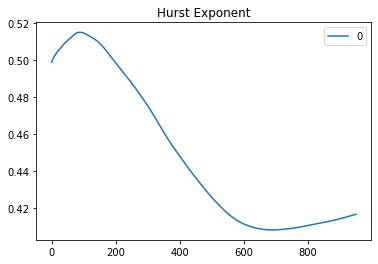

In [ ]:
def hurst_plot(df):
    h = []
    for e in range(50,1000):
        h.append(hurst(df, e))
    return h
pd.DataFrame(hurst_plot(BVSP)).plot(title="Hurst Exponent")

In [ ]:
def my_hurst(x, lag):
    z_ajustado = []
    rs = []
    for e in range(0,1+len(x)-lag):
        #print("//")
        std = np.std(x[e:lag+1+e])  #ok
        #print("std " +str(std))
        mean = np.mean(x[e:lag+e]) #ok
        #print("mean " +str(mean))

        if e <= lag:
            z_ajustado.append(x[-1+lag+e] - mean)
            #print("z_ajustado " +str(z_ajustado[:lag+e]))
            max = np.max(np.array(z_ajustado[:lag+e]))      
            #print("max " +str(max)) 
            min = np.min(np.array(z_ajustado[:lag+e]))
            #print("min " +str(min))
        
        else:        
            z_ajustado.append(x[-1+lag+e] - mean)
            #print("z_ajustado " +str(z_ajustado[e-lag:e]))
            max = np.max(np.array(z_ajustado[e-lag:e]))       
            #print("max " +str(max)) 
            min = np.min(np.array(z_ajustado[e-lag:e]))
            #print("min " +str(min))            
        rs.append((max - min)/std)
    pd.DataFrame(rs[lag:]).plot()     
    hurst = np.log2(rs[lag:])/np.log2(range(lag,len(rs)))
    pd.DataFrame(hurst).plot()    
    print(np.mean(hurst))    
    return rs

0.18228589255040456


[0.0,
 0.18780419810355192,
 0.338598109193219,
 0.33701447540080415,
 0.33533856742786367,
 0.3338378628960322,
 0.332536572804781,
 0.3401331041186754,
 0.33830386880990176,
 0.45169421739004234,
 0.449707530765948,
 0.44844613814226425,
 0.6482186578375326,
 0.8226725965134504,
 0.8425502008375781,
 0.840428677395859,
 0.8749535464538417,
 1.0654756210637046,
 1.0626214903150328,
 1.0595131351764302,
 1.055413008921157,
 1.0515234145430383,
 1.0482506745745075,
 1.045479788340934,
 1.0427040202584308,
 1.0403770195436557,
 1.0390814772658192,
 1.096926717320613,
 1.0950344326728094,
 1.0930497340451397,
 1.0907361882038293,
 1.0878608532657177,
 1.0851336684026536,
 1.0822848994009122,
 1.0794652991079137,
 1.076286548863408,
 1.0729634398026395,
 1.0700623540959566,
 1.0679541384440954,
 1.066485161819593,
 1.1383287932641215,
 1.1364001992180854,
 1.1343078019844588,
 1.1320298613154753,
 1.1296425148301317,
 1.127213661996795,
 1.125421098800793,
 1.1238133330943598,
 1.122115258

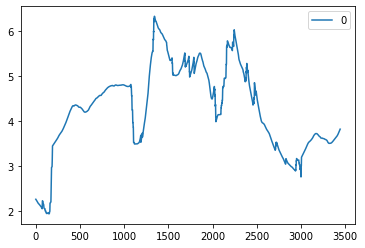

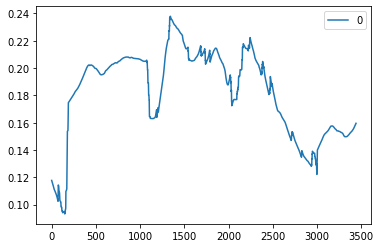

In [ ]:
my_hurst(BVSP["Close"], 1000)

In [ ]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [ ]:
# Create a Gometric Brownian Motion
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
np.random.seed(0)

gbm = log(cumsum(randn(100000))+1000)
plt.plot(gbm)
plt.show()
#Calculate Hurst Exponent for GBM
print("Hurst(GBM):   %s" % hurst(df))

0.10788213694861883


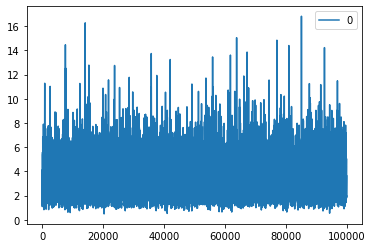

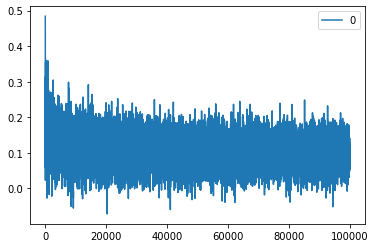

In [ ]:
rs = my_hurst(gbm, 15)

In [ ]:
np.polyfit(np.log(np.array(range(1,len(rs[0])+1))), np.log(rs[0]), 1)
 

In [ ]:
hurst = np.polyfit(np.log(np.array(range(1,len(rs[0][1:])+1))), np.log(rs[0][1:]), 1)
print(hurst)

In [ ]:
for e in range(10, 1000,100):
   print( my_hurst(df, e)[2])

In [ ]:
np.polyfit(np.log(np.array(range(1,len(rs[0])+1))), np.log(rs[0]), 1)

array([0.12332154, 1.5230055 ])

In [ ]:
def plot_hurst(series_imported):
    hurst_pd = []
    for e in range((len(series_imported[1]))):
      hurst = []
      for i in range(4,len(series_imported[1][e]),500):     
          valor = hurst(series_imported[1][e],i)         
          hurst.append(valor)   
      fig = plt.figure(figsize=(25,10))
      ax1 = fig.add_subplot(222)         
      title_hurst= "Hurst Exponent " + str(Indices[e])    
      pd.DataFrame(hurst).plot(title=title_hurst, fig=fig, ax=ax1)
      hurst_pd.append(pd.DataFrame(hurst))
    return hurst_pd

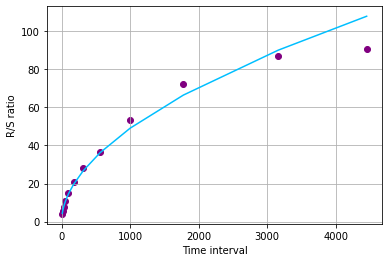

H=0.5275, c=1.2835


In [ ]:
from hurst import compute_Hc, random_walk
rw = random_walk(100000, proba=0.5, min_lookback=1, max_lookback=100, cumprod=False)

H, c, data = compute_Hc(df,  kind='random_walk' ,simplified=True)
f, ax = plt.subplots()
ax.plot(data[0], c*data[0]**H, color="deepskyblue")
ax.scatter(data[0], data[1], color="purple")
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()
print("H={:.4f}, c={:.4f}".format(H,c))

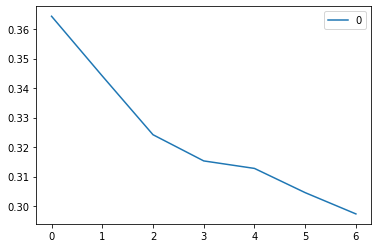

In [ ]:
pd.DataFrame(np.log(data[1])/np.log(data[0])).plot()

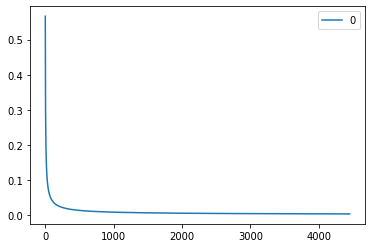

In [ ]:
rs = []
t = []
lg = []
for e in range(3,len(df)):
    t.append(e)
    rs.append(c*e**H)

rs = np.array(rs)
t = np.array(t)
pd.DataFrame(rs/t).plot()

In [ ]:
#https://github.com/erykml/medium_articles/blob/master/Time%20Series/hurst_exponent.ipynb
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""    
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    #print(tau)
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [ ]:
def plot_hurst(series_imported):   
    e_h_df = []
    for e in range(len(Indices)):
        e_h = []
        for i in range(5,len(series_imported[1][e]),50):  
            e_h.append(get_hurst_exponent(series_imported[1][e].values, i))
        e_h_df.append(e_h)
        title_hurst= "Hurst Exponent " + str(Indices[e])     
        pd.DataFrame(e_h).plot(title=title_hurst)
    return e_h_df

In [ ]:
import neurokit2 as nk
nk.complexity_delay([np.array(data_train)], show=True)
nk.complexity_embedding(df, delay=2, dimension=5, show=False)

#### Dimension

### Teste ADF

In [ ]:
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

class Unit_root:
    def __init__(self,index_name):
        self.index_name = index_name
        self.data_train = pd.read_csv(r"data\normalized\^"+str(self.index_name) +str(".csv"),index_col='Date')[index_train[0]:index_train[1]]
        self.data_complete = pd.read_csv(r"data\normalized\^"+str(self.index_name) +str(".csv"),index_col='Date')
        self.length = len(self.data_train)
    
    def adf(self, data): # https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/
        (self.statistic, self.p_value, self.n_lags, self.nobs, self.critical_values, self.icbest) = adfuller(data, autolag='AIC') 
                # Format Output
        print(f'ADF Statistic: {self.statistic}')
        print(f'p-value: {self.p_value}')
        print(f'n_lags: {self.n_lags}')
        
        for key, value in self.critical_values.items():
            print('Critial Values:')
            print(f'   {key} : {value}')       
        print(f'Result: The series is {"not " if self.p_value > 0.05 else ""}stationary')    
        return self.p_value
    

    def kpss(self): #https://www.machinelearningplus.com/time-series/kpss-test-for-stationarity/        
        self.statistic, self.p_value, self.n_lags, self.critical_values = kpss(self.data_train)            
        # Format Output
        print(f'KPSS Statistic: {self.statistic}')
        print(f'p-value: {self.p_value}')
        print(f'n_lags: {self.n_lags}')
        
        for key, value in self.critical_values.items():
            print('Critial Values:')
            print(f'   {key} : {value}')
        print(f'Result: The series is {"not " if self.p_value < 0.05 else ""}stationary')
        return self.kpss
    
    def diff(self):             
        self.integration = 0   
        self.data_complete_diff = self.data_complete
        if adfuller(self.data_train, autolag='AIC')[1]  > 0.05:
            self.data_train_diff = self.data_train.diff(1)                
            self.data_train_diff.dropna(inplace=True)           
            self.data_complete_diff = self.data_complete.diff(1)  
            self.data_complete_diff.dropna(inplace=True)        
            self.integration += 1 
            while adfuller(self.data_train_diff, autolag='AIC')[1] > 0.05:
                self.data_train_diff = self.data_train_diff.diff(1)   
                self.data_train_diff.dropna(inplace=True)                    
                self.data_complete_diff = self.data_complete.diff(1)  
                self.data_complete_diff.dropna(inplace=True)
                self.integration += 1
                print(f'Result: The series is {"not " if self.p_value < 0.05 else ""}stationary')

        else:
            pass         
        return self.data_complete_diff, self.integration 
    
    def undiff(self, data, integration):
        self.data_complete_undiff = data
        for i in range(integration):
            self.data_complete_undiff = self.data_complete_undiff + self.data_complete.shift()  
            self.data_complete_undiff.dropna(inplace=True)
        return self.data_complete_undiff 
    
for e in Indices:
    differentiated = Unit_root(e).diff()[0]
    filepath_differentiated = Path(str(r"data\differentiated\^")+str(e)+str('.csv'))
    filepath_differentiated.parent.mkdir(parents=True, exist_ok=True)          
    differentiated.to_csv(filepath_differentiated) 

In [ ]:
Unit_root("BVSP").undiff(pd.read_csv(r"data\differentiated\^"+str("BVSP") +str(".csv"),index_col='Date'),1)

Close
Date                
2000-01-04  0.191855
2000-01-05  0.196694
2000-01-06  0.194999
2000-01-07  0.197480
2000-01-10  0.206235
...              ...
2021-12-23  1.285276
2021-12-27  1.293135
2021-12-28  1.284945
2021-12-29  1.275649
2021-12-30  1.284429

[5441 rows x 1 columns]

# Preprocessamento

## Evaluation


In [3]:
## Evaluation
import math
from tabnanny import verbose
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score, mean_absolute_percentage_error

import matplotlib.pyplot as plt
def visualize_loss(history, title):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    plt.plot((loss_train), 'g', label='Training loss')
    plt.plot((loss_val), 'b', label='validation loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

class Evaluate():
    def __init__(self, prediction, target):
        self.prediction = prediction
        self.target = target
        
    def mse(self):
        return mean_squared_error(self.target, self.prediction)
    
    def mape(self):
        return mean_absolute_percentage_error(self.target, self.prediction)
    
    def mae(self):
        return mean_absolute_error(self.target, self.prediction)
    
    def rmse(self):
        return math.sqrt(mean_squared_error(self.target, self.prediction))
    
    def r2(self):
        return r2_score(self.target, self.prediction)
    
    def pocid(self):
        y_true = np.asarray(self.target).reshape(-1)
        y_pred = np.asarray(self.prediction).reshape(-1)

        true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
        pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

        mult = true_sub * pred_sub
        result = 0
        for m in mult:
            if m > 0:
                result = result + 1
        return (100 * (result / len(y_true)))
    
    def avr(self):
        y = self.prediction.reset_index(drop=True).values.flatten()
        f = self.target.reset_index(drop=True).values.flatten()
        df = pd.DataFrame({'f_i':f, 'y_i': y})
        
        df['ej^2'] = np.square(df['f_i'] - df['y_i'])
        df['denominator'] = np.square(df['y_i'] - np.mean(df['f_i']))
        
        return np.sum(df['ej^2'])/np.sum(df['denominator'])
    
    def u1(self):
        y = self.prediction.reset_index(drop=True).values.flatten()
        f = self.target.reset_index(drop=True).values.flatten()
        df = pd.DataFrame({'f_i':f, 'y_i': y})
        df['(y_i - f_i)^2'] = np.square(df['y_i'] - df['f_i'])
        df['y_i^2'] = np.square(df['y_i'])
        df['f_i^2'] = np.square(df['f_i'])
        return (np.sqrt(np.mean(df['(y_i - f_i)^2'])))/(np.sqrt(np.mean(df['y_i^2']))+np.sqrt(np.mean(df['f_i^2'])))

    def u2(self):
        y = self.prediction.reset_index(drop=True).values.flatten()
        f = self.target.reset_index(drop=True).values.flatten()
        df = pd.DataFrame({'f_i+1':f, 'y_i+1': y})
        df['y_i'] = df['y_i+1'].shift(periods=1)
        
        df['numerator'] = np.square((df['f_i+1'] - df['y_i+1']) / df['y_i'])
        df['denominator'] = np.square((df['y_i+1'] - df['y_i']) / df['y_i'])
        df.dropna(inplace=True)
        return np.sqrt(np.sum(df['numerator'])/np.sum(df['denominator']))
    
    def u3(self):
        y = self.prediction.reset_index(drop=True).values.flatten()
        f = self.target.reset_index(drop=True).values.flatten()
        df = pd.DataFrame({'y_i': y, 'f_i':f})
        
        df['numerator'] = np.sqrt((df['f_i'] - df['y_i']) )
        df['denominator'] = np.sqrt(df['y_i'])
        
        return np.sum(df['numerator'])/np.sum(df['denominator'])    
    
    def u4(self):
        y = self.prediction.reset_index(drop=True).values.flatten()
        f = self.target.reset_index(drop=True).values.flatten()
        df = pd.DataFrame({'y_i': y, 'f_i':f})
        df['f_i+1'] = df['f_i'].shift(periods=-1)
        
        df['numerator'] = np.square((df['f_i'] - df['y_i']))
        df['denominator'] = np.square((df['f_i'] - df['f_i+1']))
        df.dropna(inplace=True)
        return np.sum(df['numerator'])/np.sum(df['denominator'])
    
    def EF(self):
        return self.pocid()/(1+self.mse() + self.mape() + self.u4() +self.avr())
    
    def all(self, verbose=False):    
        mse = self.mse()     
        mape = self.mape()    
        mae = self.mae()        
        rmse = self.rmse()       
        pocid = self.pocid()
        r2 = self.r2()
        avr = self.avr()
        theilsu1 = self.u1()       
        # theilsu2 = self.u2()     
        # theilsu3 = self.u3()       
        theilsuRicardo = self.u4()
        Evaluate_Function = self.EF()
        
        if verbose == True:
            print('MSE: (Mean Squared Error) '+str(mse))            
            print('MAPE: (Mean Absolute Percentage Erro) '+str(mape))
            print('MAE: Mean Absolute Error '+str(mae))
            print('RMSE: (Root Mean Square Error): '+str(rmse))
            print('POCID (Prediction of Change in Direction): '+str(pocid))
            print('R2 (Coeficiente de Determinação): '+str(r2))            
            print('ARV (Average Relative Variance): '+str(avr))
            print('Theil’s U1 : '+str(theilsu1))
            # print('Theil’s U2 : '+str(theilsu2))             
            # print('Theil’s U3 : '+str(theilsu3)) 
            print('Theil’s U2 : '+str(theilsuRicardo))            
            print('Evaluate Function : '+str(Evaluate_Function)) 
        # result = pd.DataFrame(index= ["MSE", "MAPE","MAE","RMSE", "POCID", "R2 ", "AVR", "Theil’s U1", "Theil’s U2", "Evaluate Function"])
        
        return mse, mape, mae, rmse, pocid, r2, avr, theilsu1, theilsuRicardo, Evaluate_Function   

In [ ]:
RW_test = pd.DataFrame(index= ["MSE", "MAPE","MAE","RMSE", "POCID", "R2 ", "AVR", "Theil’s U1", "Theil’s U2"])
RW_test.index.name = "Test"
for e, p in zip(range(0, len(result)), range(50,3000,250)):
    RW_test[str(p)] = result[e][2]
RW_train = RW_train.transpose()
RW_valid = RW_valid.transpose()
RW_test = RW_test.transpose()

## Windows(Train, Valid Test)

In [5]:
import pandas as pd
import neurokit2 as nk
class WindowGenerator:
    def __init__(self, index_name, delay, window_size=1 , diff = False):   
        self.delay = delay    
        self.index_name = index_name        
        self.data_window = window_size          
        self.data_complete = pd.read_csv("data//normalized\^{}{}".format(self.index_name,".csv"), index_col='Date')   
        
        self.data_complete_diff = pd.DataFrame.dropna((self.data_complete - self.data_complete.shift()))   
        if diff == True:     
            self.data_complete_diff = pd.DataFrame.dropna((self.data_complete - self.data_complete.shift()))        
            # self.data_complete = MinMax(self.data_complete_diff[config["Train"]["start"]:config["Train"]["end"]], -0.01, 0.01).transform(self.data_complete_diff )
            self.data_complete = self.data_complete_diff*1
            
        self.seq_x_All = nk.complexity_embedding(self.data_complete["Close"][:-1], delay= self.delay , dimension=self.data_window, show=False)        
        self.seq_x_All = pd.DataFrame(self.seq_x_All, index=self.data_complete[self.data_window:].index)    
           
        self.seq_y_All = pd.DataFrame(self.data_complete["Close"][self.data_window:].values, index= self.seq_x_All.index)          
        # self.seq_y_All = pd.DataFrame(self.data_complete["Close"][self.data_window-1:-1].values, index= self.seq_x_All.index)  #Fake Ajuste PAP
         
    def TrainDataAug(self): 
        self.train_data = self.data_complete[config["Train"]["start"]:config["Train"]["end"]]        
        # self.train_data = self.data_complete        
        self.DataAug =  pd.concat([self.train_data, 
                                   jitter(self.train_data), 
                                   scaling(self.train_data)
                                   ])    
        self.seq_x = nk.complexity_embedding(self.DataAug["Close"][:-1], delay = self.delay , dimension =self.data_window, show=False)        
        self.seq_x = pd.DataFrame(self.seq_x, index=self.DataAug[self.data_window:].index)   
        self.seq_y = pd.DataFrame(self.DataAug["Close"][self.data_window:].values, index= self.DataAug[self.data_window:].index)     
        return self.seq_x, self.seq_y    
    
    def Train(self):    
        return self.seq_x_All[config["Train"]["start"]:config["Train"]["end"]], self.seq_y_All[config["Train"]["start"]:config["Train"]["end"]] 
    
    def Valid(self):            
        return self.seq_x_All[config["Valid"]["start"]:config["Valid"]["end"]], self.seq_y_All[config["Valid"]["start"]:config["Valid"]["end"]]    
    
    def Test(self):   
        return self.seq_x_All[config["Test"]["start"]:config["Test"]["end"]], self.seq_y_All[config["Test"]["start"]:config["Test"]["end"]]
    
    def Undiff(self, data_predicted):   
        self.data_predicted = data_predicted   
        self.original_data = pd.read_csv("data//normalized\^{}{}".format(self.index_name,".csv"), index_col='Date')   
        undiff = self.original_data.shift()[data_predicted.index[0]:data_predicted.index[-1]].values + self.data_predicted.values  
        return pd.DataFrame(undiff, index=data_predicted.index)  
    
WG= WindowGenerator("IXIC", delay= 1, window_size=3, diff=True)

In [7]:
WG.seq_x_All , WG.seq_y_All

(                   0         1         2
 Date                                    
 2000-01-07 -0.041974 -0.004418 -0.027514
 2000-01-10 -0.004418 -0.027514  0.028443
 2000-01-11 -0.027514  0.028443  0.030558
 2000-01-12  0.028443  0.030558 -0.023502
 2000-01-13  0.030558 -0.023502 -0.013019
 ...              ...       ...       ...
 2021-12-23 -0.034526  0.065881  0.033073
 2021-12-27  0.065881  0.033073  0.024051
 2021-12-28  0.033073  0.024051  0.039858
 2021-12-29  0.024051  0.039858 -0.016379
 2021-12-30  0.039858 -0.016379 -0.002835
 
 [5531 rows x 3 columns],
                    0
 Date                
 2000-01-07  0.028443
 2000-01-10  0.030558
 2000-01-11 -0.023502
 2000-01-12 -0.013019
 2000-01-13  0.019608
 ...              ...
 2021-12-23  0.024051
 2021-12-27  0.039858
 2021-12-28 -0.016379
 2021-12-29 -0.002835
 2021-12-30 -0.004511
 
 [5531 rows x 1 columns])

In [ ]:
import tensorflow as tf

train = pd.read_csv("data//normalized\^{}{}".format("BVSP",".csv"), index_col='Date')["2000-01-03":"2016-12-31"]
dataset = tf.data.Dataset.from_tensor_slices(train)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

for X, y in dataset:
    
    print("Input:", X, "Target:", y)
    print("Input:", X.numpy(), "Target:", y.numpy())

## Data Augmentation

In [8]:
def jitter(x, sigma=0.01):
    # https://arxiv.org/pdf/1706.00527.pdf
    return x + np.random.normal(loc=0., scale=sigma, size=x.shape)
def scaling(x, sigma=0.02):
    # https://arxiv.org/pdf/1706.00527.pdf
    factor = np.random.normal(loc=1., scale=sigma, size=(x.shape[0]))
    return np.multiply(x, factor[:,np.newaxis])

def window_slice(x, reduce_ratio=0.5):
    # https://halshs.archives-ouvertes.fr/halshs-01357973/document
    target_len = np.ceil(reduce_ratio*x.shape[1]).astype(int)
    if target_len >= x.shape[1]:
        return x
    starts = np.random.randint(low=0, high=x.shape[1]-target_len, size=(x.shape[0])).astype(int)
    ends = (target_len + starts).astype(int)
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            ret[i,:,dim] = np.interp(np.linspace(0, target_len, num=x.shape[1]), np.arange(target_len), pat[starts[i]:ends[i],dim]).T
    return ret

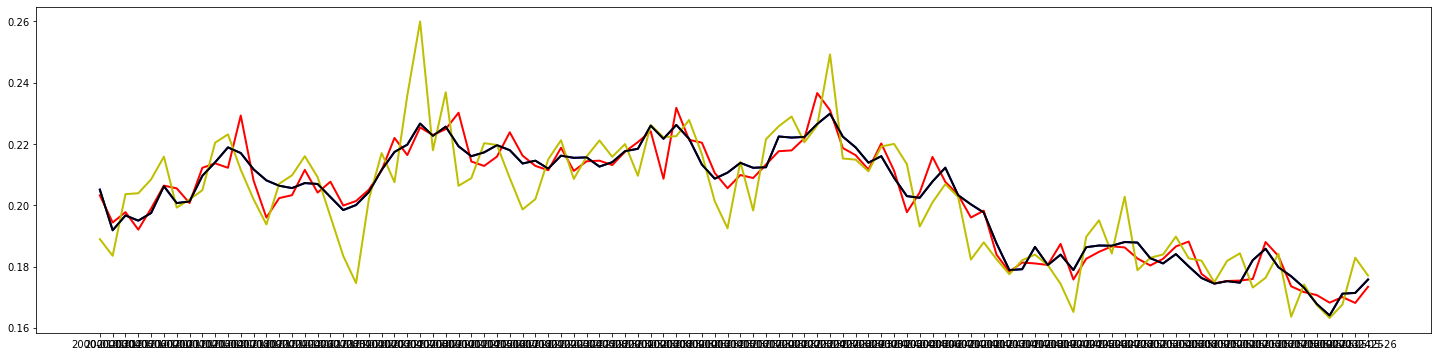

In [12]:
train = pd.read_csv("data//normalized\^{}{}".format("BVSP",".csv"), index_col='Date')["2000-01-03":"2016-12-31"]
scaling1 = scaling(train)
jitter1 = jitter(train)
WS = window_slice(train)

janelas = 0 
janelas1 = 100
plt.figure(figsize=(25,6))
plt.plot(train[janelas:janelas1], 'b',linewidth=2) # plotting t, b separately
plt.plot(scaling1[janelas:janelas1], 'r',  linewidth=2) # plotting t, a separately
plt.plot(jitter1[janelas:janelas1], 'y',  linewidth=2) # plotting t, a separately  
plt.plot(WS[janelas:janelas1], 'k',  linewidth=2) # plotting t, a separately  
plt.show()

# Models


## ARIMA


In [13]:
import pmdarima as pm
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

indices = "BVSP"
Data = pd.read_csv(r"data\normalized\^"+str(indices) +str(".csv"),index_col='Date')
Train = Data[index_train[0]:index_train[1]]
Valid = Data[index_valid[0]:index_valid[1]]
Test = Data[index_test[0]:index_test[1]]

auto_arima = pm.auto_arima(Train.values, 
                      test='adf',
                      start_p=5, start_q=5,
                      max_p=25, max_q=25,
                      start_P=1, start_Q = 1,
                      max_P =25, max_Q =25,
                      m=12,             
                      d=1,    
                      max_order=500,      
                      seasonal=False,
                      D=None, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True,                       
                      information_criterion="aic",
                      scoring='mse',
                      n_jobs= -1,
                      stepwise=True)

print(auto_arima.summary())

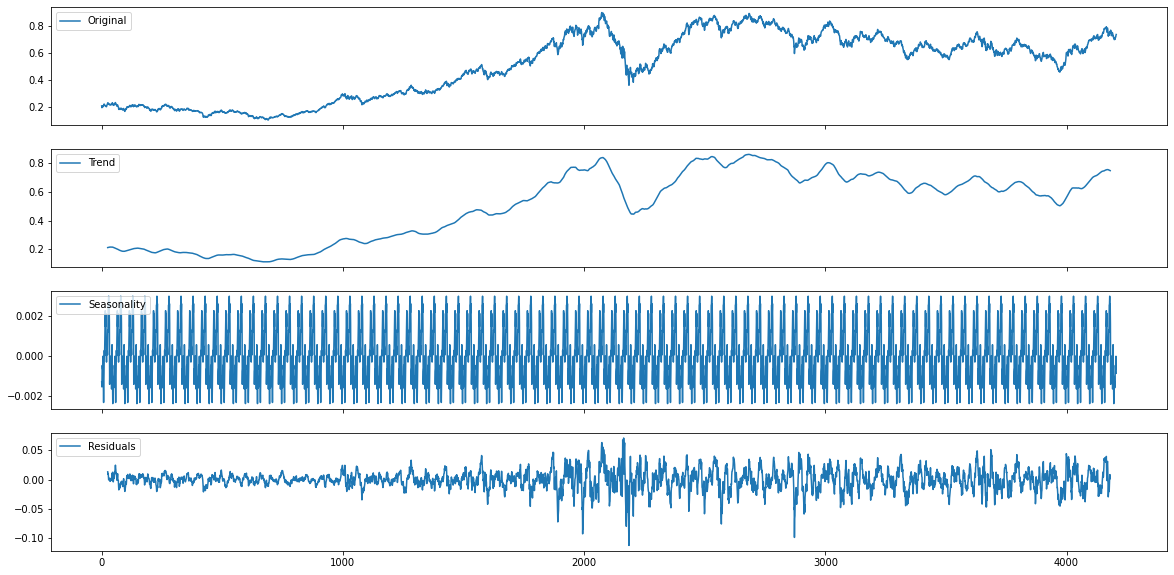

In [131]:
from statsmodels.tsa.seasonal import seasonal_decompose
ts_dicomposition = seasonal_decompose(np.array(Train["Close"]), model='additive', period=50)
trend_estimate = ts_dicomposition.trend
seasonal_estimate = ts_dicomposition.seasonal
residual_estimate = ts_dicomposition.resid

# Plotting the time series and it's components together
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(20)

# First plot to the Original time series
axes[0].plot(np.array(Train["Close"]), label='Original') 
axes[0].legend(loc='upper left');
# second plot to be for trend
axes[1].plot(trend_estimate, label='Trend')
axes[1].legend(loc='upper left');
# third plot to be Seasonality component
axes[2].plot(seasonal_estimate, label='Seasonality')
axes[2].legend(loc='upper left');
# last last plot to be Residual component
axes[3].plot(residual_estimate, label='Residuals')
axes[3].legend(loc='upper left');

In [75]:
np.array(Train["Close"])

array([0.20510546, 0.19185522, 0.19669358, ..., 0.71800878, 0.7313327 ,
       0.73679735])

In [77]:
trend_estimate

array([nan, nan, nan, ..., nan, nan, nan])

In [84]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(Train.values, order=(10,1,0))

model_fit = model.fit()
train_predict = model_fit.predict(n_periods=Train, return_conf_int=True)
train_predict = pd.DataFrame(train_predict).rename(columns={0: "Predict"}) 

# Evaluate an ARIMA model using a walk-forward validation
train, valid, test = Train.values, Valid.values, Test.values

history = [x for x in train]
valid_predictions = list()
test_predictions = list()

# walk-forward Validation
for t in range(len(valid)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    valid_predictions.append(yhat)
    obs = valid[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
    # print((t/len(valid)))

# walk-forward Test
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    test_predictions.append(yhat)
    
    obs = test[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
    # print((t/len(valid))) 

In [85]:
train_predict["Predict"]

0       0.000000
1       0.205105
2       0.192073
3       0.196826
4       0.195666
          ...   
4202    0.700467
4203    0.707882
4204    0.717361
4205    0.717538
4206    0.730252
Name: Predict, Length: 4207, dtype: float64

In [86]:
Train_results = pd.DataFrame()
Train_results["Train"] = Train
Train_results["Train Predict"] = train_predict["Predict"].values
Train_results["Resido"] = Train_results["Train"] - Train_results["Train Predict"]
Train_results[:]

Train  Train Predict    Resido
Date                                         
2000-01-03  0.205105       0.000000  0.205105
2000-01-04  0.191855       0.205105 -0.013250
2000-01-05  0.196694       0.192073  0.004621
2000-01-06  0.194999       0.196826 -0.001827
2000-01-07  0.197480       0.195666  0.001814
...              ...            ...       ...
2016-12-23  0.708676       0.700467  0.008209
2016-12-26  0.717063       0.707882  0.009181
2016-12-27  0.718009       0.717361  0.000647
2016-12-28  0.731333       0.717538  0.013795
2016-12-29  0.736797       0.730252  0.006545

[4207 rows x 3 columns]

In [23]:
Valid_results = pd.DataFrame()
Valid_results["Valid"] = Valid
Valid_results["Valid Predict"] = pd.DataFrame(valid_predictions, index= Valid.index)
Valid_results["Resido"] = Valid_results["Valid"] - Valid_results["Valid Predict"]
Valid_results

Valid  Valid Predict    Resido
Date                                         
2017-01-02  0.728963       0.736797 -0.007835
2017-01-03  0.756286       0.728963  0.027323
2017-01-04  0.753523       0.756286 -0.002763
2017-01-05  0.759442       0.753523  0.005919
2017-01-06  0.754456       0.759442 -0.004986
...              ...            ...       ...
2018-12-20  1.044316       1.049289 -0.004973
2018-12-21  1.049572       1.044316  0.005256
2018-12-26  1.042683       1.049572 -0.006889
2018-12-27  1.046661       1.042683  0.003979
2018-12-28  1.076465       1.046661  0.029804

[492 rows x 3 columns]

In [87]:
Test_results = pd.DataFrame()
Test_results["Test"] = Test
Test_results["Test Predict"] = pd.DataFrame(test_predictions, index= Test.index)
Test_results["Resido"] = Test_results["Test"] - Test_results["Test Predict"]
Test_results

Test  Test Predict    Resido
Date                                        
2019-01-02  1.114841      1.076465  0.038375
2019-01-03  1.121619      1.114841  0.006779
2019-01-04  1.125021      1.121619  0.003402
2019-01-07  1.123277      1.125021 -0.001744
2019-01-08  1.127366      1.123277  0.004089
...              ...           ...       ...
2020-12-22  1.425969      1.421892  0.004077
2020-12-23  1.444500      1.425969  0.018531
2020-12-28  1.459162      1.444500  0.014662
2020-12-29  1.464369      1.459162  0.005207
2020-12-30  1.462294      1.464369 -0.002075

[496 rows x 3 columns]

In [88]:
RW = pd.DataFrame(index= ["MSE", "MAPE","MAE","RMSE", "POCID", "R2 ","ARV", "Theil’s U1", "Theil’s U2"])
RW["Train"] = Evaluate(train_predict[1:],Train[1:]).all()
RW["Valid"] = Evaluate(pd.DataFrame(valid_predictions)[1:],Valid[1:]).all()
RW["Test"] = Evaluate(pd.DataFrame(test_predictions)[1:],Test[1:]).all()
RW

Train      Valid       Test
MSE          0.000085   0.000147   0.000538
MAPE         0.013562   0.009758   0.013384
MAE          0.006410   0.008992   0.015372
RMSE         0.009245   0.012130   0.023200
POCID       49.595816  49.287169  45.858586
R2           0.998491   0.985989   0.967612
ARV          0.001509   0.013985   0.032573
Theil’s U1   0.008288   0.006579   0.009448
Theil’s U2   0.993876   0.998018   1.000156

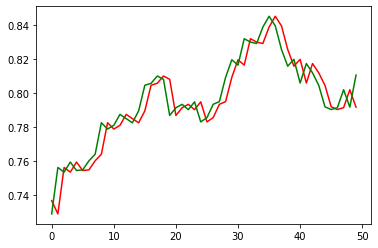

In [89]:
plt.plot(pd.DataFrame(valid_predictions)[0:50], 'r')
plt.plot(Valid.values[0:50], 'g')

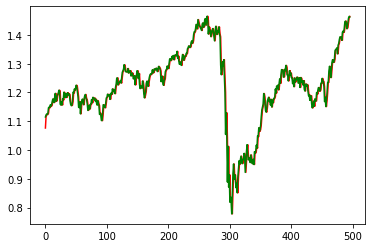

In [90]:
plt.plot(pd.DataFrame(test_predictions), 'r')
plt.plot(Test.values, 'g')

## ARIMA + MLP

In [107]:
train,valid,test = train_valid_test(Indices="BVSP", delay=1, window_size=250, year=None)
x_train, y_train = train[0][:-1] ,Train_results["Resido"].shift(-1)[:-1]*100
x_valid, y_valid = valid[0][:-1] ,Valid_results["Resido"].shift(-1)[:-1]*100
x_test, y_test = test[0][:"2021"][:-1] , Test_results["Resido"].shift(-1)[:-1]*100

y_train = y_train[x_train.index]
y_valid = y_valid[x_valid.index]

In [108]:
y_train

Date
2001-01-03    0.132274
2001-01-04   -0.279335
2001-01-05    0.303229
2001-01-08    0.541161
2001-01-09   -0.076309
                ...   
2016-12-22    0.820912
2016-12-23    0.918082
2016-12-26    0.064737
2016-12-27    1.379457
2016-12-28    0.654498
Name: Resido, Length: 3957, dtype: float64

In [109]:
K = train[0]
K["Y"] = Train_results["Train"].shift(-1)
K["Y Resido"] = Train_results["Resido"].shift(-1)
K[:-1]

0         1         2         3         4         5  \
Date                                                                     
2001-01-03  0.205105  0.191855  0.196694  0.194999  0.197480  0.206235   
2001-01-04  0.191855  0.196694  0.194999  0.197480  0.206235  0.200721   
2001-01-05  0.196694  0.194999  0.197480  0.206235  0.200721  0.201262   
2001-01-08  0.194999  0.197480  0.206235  0.200721  0.201262  0.209625   
2001-01-09  0.197480  0.206235  0.200721  0.201262  0.209625  0.214045   
...              ...       ...       ...       ...       ...       ...   
2016-12-22  0.527704  0.531020  0.537712  0.534630  0.533279  0.529546   
2016-12-23  0.531020  0.537712  0.534630  0.533279  0.529546  0.514699   
2016-12-26  0.537712  0.534630  0.533279  0.529546  0.514699  0.518113   
2016-12-27  0.534630  0.533279  0.529546  0.514699  0.518113  0.510180   
2016-12-28  0.533279  0.529546  0.514699  0.518113  0.510180  0.496942   

                   6         7         8         9  ...       242       243  \
Date                                                ...                       
2001-01-03  0.200721  0.201262  0.209625  0.214045  ...  0.176763  0.175326   
2001-01-04  0.201262  0.209625  0.214045  0.218896  ...  0.175326  0.177131   
2001-01-05  0.209625  0.214045  0.218896  0.217054  ...  0.177131  0.178887   
2001-01-08  0.214045  0.218896  0.217054  0.211737  ...  0.178887  0.183689   
2001-01-09  0.218896  0.217054  0.211737  0.208139  ...  0.183689  0.184585   
...              ...       ...       ...       ...  ...       ...       ...   
2016-12-22  0.514699  0.518113  0.510180  0.496942  ...  0.725180  0.712053   
2016-12-23  0.518113  0.510180  0.496942  0.495923  ...  0.712053  0.714312   
2016-12-26  0.510180  0.496942  0.495923  0.487794  ...  0.714312  0.714227   
2016-12-27  0.496942  0.495923  0.487794  0.482439  ...  0.714227  0.698533   
2016-12-28  0.495923  0.487794  0.482439  0.475440  ...  0.698533  0.704329   

                 244       245       246       247       248       249  \
Date                                                                     
2001-01-03  0.177131  0.178887  0.183689  0.184585  0.186624  0.201041   
2001-01-04  0.178887  0.183689  0.184585  0.186624  0.201041  0.201974   
2001-01-05  0.183689  0.184585  0.186624  0.201041  0.201974  0.198720   
2001-01-08  0.184585  0.186624  0.201041  0.201974  0.198720  0.200586   
2001-01-09  0.186624  0.201041  0.201974  0.198720  0.200586  0.205670   
...              ...       ...       ...       ...       ...       ...   
2016-12-22  0.714312  0.714227  0.698533  0.704329  0.705115  0.700301   
2016-12-23  0.714227  0.698533  0.704329  0.705115  0.700301  0.708676   
2016-12-26  0.698533  0.704329  0.705115  0.700301  0.708676  0.717063   
2016-12-27  0.704329  0.705115  0.700301  0.708676  0.717063  0.718009   
2016-12-28  0.705115  0.700301  0.708676  0.717063  0.718009  0.731333   

                   Y  Y Resido  
Date                            
2001-01-03  0.201974  0.001323  
2001-01-04  0.198720 -0.002793  
2001-01-05  0.200586  0.003032  
2001-01-08  0.205670  0.005412  
2001-01-09  0.204970 -0.000763  
...              ...       ...  
2016-12-22  0.708676  0.008209  
2016-12-23  0.717063  0.009181  
2016-12-26  0.718009  0.000647  
2016-12-27  0.731333  0.013795  
2016-12-28  0.736797  0.006545  

[3957 rows x 252 columns]

In [148]:
import tensorflow as tf
import keras
from keras.models import Sequential,load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense

window_size= 120
epochs = 100
batch_size = None

train,valid,test = train_valid_test(Indices="BVSP", delay=1, window_size=window_size, year=None)
x_train, y_train = train[0][:-1] ,Train_results["Resido"].shift(-1)[:-1]*100
x_valid, y_valid = valid[0][:-1] ,Valid_results["Resido"].shift(-1)[:-1]*100
x_test, y_test = test[0][:"2021"][:-1] , Test_results["Resido"].shift(-1)[:-1]*100


timelag = len(x_train.values[0])
y_train = y_train[x_train.index]
y_valid = y_valid[x_valid.index]

model = Sequential()  
model.add(Dense(timelag, activation='relu', input_dim=timelag))
model.add(Dense(round(4*np.sqrt(3*timelag))))
model.add(Dense(1))
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6), loss = "mse")

checkpoint_filepath = 'best_model'
es = tf.keras.callbacks.EarlyStopping(monitor='loss', verbose=1, patience=200, restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', verbose=1, save_best_only=True)  

history = model.fit(x_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(x_valid, y_valid),
                    callbacks=[es,mc])
history

Epoch 1/100
127/128 [============================>.] - ETA: 0s - loss: 1.2620
Epoch 1: val_loss improved from inf to 1.46970, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets
128/128 [==============================] - 1s 7ms/step - loss: 1.2579 - val_loss: 1.4697
Epoch 2/100
107/128 [========================>.....] - ETA: 0s - loss: 0.8588
Epoch 2: val_loss improved from 1.46970 to 1.46951, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets
128/128 [==============================] - 1s 6ms/step - loss: 0.8740 - val_loss: 1.4695
Epoch 3/100
120/128 [===========================>..] - ETA: 0s - loss: 0.8683
Epoch 3: val_loss did not improve from 1.46951
128/128 [==============================] - 0s 3ms/step - loss: 0.8743 - val_loss: 1.4710
Epoch 4/100
127/128 [============================>.] - ETA: 0s - loss: 0.8736
Epoch 4: val_loss improved from 1.46951 to 1.46642, saving model to best_model
INFO:tensorflow:Assets written to: 

In [160]:
y_train

Date
2000-06-26   -0.257294
2000-06-27    0.373248
2000-06-28   -0.528706
2000-06-29    0.374388
2000-06-30    0.475937
                ...   
2016-12-22    0.820912
2016-12-23    0.918082
2016-12-26    0.064737
2016-12-27    1.379457
2016-12-28    0.654498
Name: Resido, Length: 4087, dtype: float64

<AxesSubplot:>

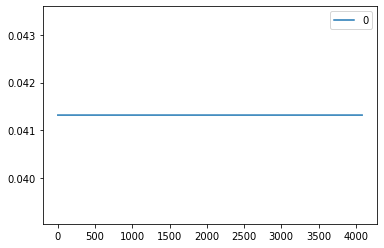

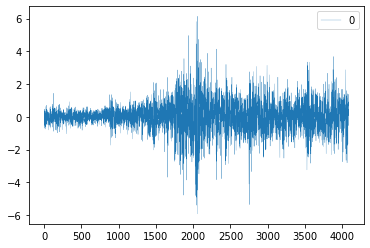

In [159]:
train_arima_resul = model.predict(x_train, verbose=0)
pd.DataFrame(train_arima_resul).plot()
pd.DataFrame(y_train.values).plot(linewidth=0.25)


## RW

In [97]:
import pandas as pd
RW_result = []
for indices in Indices:    
    Train = pd.read_csv(r"data\normalized\^"+str(indices) +str(".csv"),index_col='Date')[index_train[0]:index_train[1]]
    valid = pd.read_csv(r"data\normalized\^"+str(indices) +str(".csv"),index_col='Date')[index_valid[0]:index_valid[1]]
    test = pd.read_csv(r"data\normalized\^"+str(indices) +str(".csv"),index_col='Date')[index_test[0]:index_test[1]]

    Train["Normal"] = np.random.normal(loc=0.0, scale=0.1, size = len(Train["Close"]))
    Train["Shit"] = pd.DataFrame(Train["Close"]).shift(1)
    Train["RW"] = Train["Shit"] + Train["Normal"]

    valid["Normal"] = np.random.normal(loc=0.0, scale=0.1, size = len(valid["Close"]))
    valid["Shit"] = pd.DataFrame(valid["Close"]).shift(1)
    valid["RW"] = valid["Shit"] + valid["Normal"]

    test["Normal"] = np.random.normal(loc=0.0, scale=0.1, size = len(test["Close"]))
    test["Shit"] = pd.DataFrame(test["Close"]).shift(1)
    test["RW"] = test["Shit"] + test["Normal"]

    RW_TRAIN = Evaluate(pd.DataFrame(Train["Close"][1:]), pd.DataFrame(Train["Shit"][1:])).all()
    RW_VALID = Evaluate(pd.DataFrame(valid["Close"][1:]), pd.DataFrame(valid["Shit"][1:])).all()
    RW_TEST = Evaluate(pd.DataFrame(test["Close"][1:]), pd.DataFrame(test["Shit"][1:])).all()

    RW = pd.DataFrame(index= ["MSE", "MAPE","MAE","RMSE", "POCID", "R2 ", "ARV", "Theil’s U1", "Theil’s U2", "EF"])
    RW["Train"] = RW_TRAIN
    RW["Valid"] = RW_VALID
    RW["Test"] = RW_TEST
    RW.index.name= "RW "+ str(indices)
    RW_result.append(RW)

MSE: (Mean Squared Error) 8.602630486563916e-05
MAPE: (Mean Absolute Percentage Erro) 0.013587956881075433
MAE: Mean Absolute Error 0.006425378869181494
RMSE: (Root Mean Square Error): 0.009275036650366357
POCID (Prediction of Change in Direction): 49.738468854018066
R2 (Coeficiente de Determinação): 0.9984818450864112
ARV (Average Relative Variance): 0.001518380879014229
Theil’s U1 : 0.008315170503304416
Theil’s U2 : 1.0
Evaluate Function : 24.68174738102315
MSE: (Mean Squared Error) 0.00014713216266485266
MAPE: (Mean Absolute Percentage Erro) 0.009758363198533175
MAE: Mean Absolute Error 0.008992041251163069
RMSE: (Root Mean Square Error): 0.01212980472492664
POCID (Prediction of Change in Direction): 49.287169042769854
R2 (Coeficiente de Determinação): 0.9860144759649541
ARV (Average Relative Variance): 0.014010040448905593
Theil’s U1 : 0.006579464356664681
Theil’s U2 : 1.0
Evaluate Function : 24.352384361258387
MSE: (Mean Squared Error) 0.000538258297854978
MAPE: (Mean Absolute Per

In [101]:
for e in RW_result:
    print(e)

                Train      Valid       Test
RW BVSP                                    
MSE          0.000086   0.000147   0.000538
MAPE         0.013588   0.009758   0.013291
MAE          0.006425   0.008992   0.015372
RMSE         0.009275   0.012130   0.023200
POCID       49.738469  49.287169  45.858586
R2           0.998482   0.986014   0.967426
ARV          0.001518   0.014010   0.032387
Theil’s U1   0.008315   0.006579   0.009448
Theil’s U2   1.000000   1.000000   1.000000
EF          24.681747  24.352384  22.411411
                Train      Valid       Test
RW IXIC                                    
MSE          0.000064   0.000174   0.000751
MAPE         0.015142   0.007459   0.011849
MAE          0.005351   0.008715   0.018104
RMSE         0.008025   0.013208   0.027411
POCID       49.929841  46.706587  48.809524
R2           0.998444   0.989598   0.990814
ARV          0.001555   0.010483   0.009120
Theil’s U1   0.008759   0.005727   0.008664
Theil’s U2   1.000000   1.000000

In [28]:
import pandas as pd
Train = pd.read_csv(r"data\normalized\^"+str("BVSP") +str(".csv"),index_col='Date')[index_train[0]:index_train[1]]

Train["Normal"] = np.random.normal(loc=0.0, scale=0.1, size = len(Train["Close"]))
Train["Shit"] = pd.DataFrame(Train["Close"]).shift(1)
Train["RW"] = Train["Shit"] + Train["Normal"]

In [29]:
import pandas as pd
# MinMax(np.random.normal(scale=1,size = len(Data["Close"])), 0.1,0.9).transform(np.random.normal( scale=1,size = len(Data["Close"])))
valid = pd.read_csv(r"data\normalized\^"+str("BVSP") +str(".csv"),index_col='Date')[index_valid[0]:index_valid[1]]

valid["Normal"] = np.random.normal(loc=0.0, scale=0.1, size = len(valid["Close"]))
valid["Shit"] = pd.DataFrame(valid["Close"]).shift(1)
valid["RW"] = valid["Shit"] + valid["Normal"]
valid

Close    Normal      Shit        RW
Date                                              
2017-01-02  0.728963  0.134991       NaN       NaN
2017-01-03  0.756286 -0.080502  0.728963  0.648461
2017-01-04  0.753523  0.065054  0.756286  0.821340
2017-01-05  0.759442  0.018411  0.753523  0.771934
2017-01-06  0.754456  0.089559  0.759442  0.849001
...              ...       ...       ...       ...
2018-12-20  1.044316 -0.046147  1.049289  1.003142
2018-12-21  1.049572  0.117366  1.044316  1.161682
2018-12-26  1.042683  0.176221  1.049572  1.225792
2018-12-27  1.046661 -0.108133  1.042683  0.934549
2018-12-28  1.076465 -0.059946  1.046661  0.986715

[492 rows x 4 columns]

In [30]:
import pandas as pd
# MinMax(np.random.normal(scale=1,size = len(Data["Close"])), 0.1,0.9).transform(np.random.normal( scale=1,size = len(Data["Close"])))
test = pd.read_csv(r"data\normalized\^"+str("BVSP") +str(".csv"),index_col='Date')[index_test[0]:index_test[1]]

test["Normal"] = np.random.normal(loc=0.0, scale=0.1, size = len(test["Close"]))
test["Shit"] = pd.DataFrame(test["Close"]).shift(1)
test["RW"] = test["Shit"] + test["Normal"]
test

Close    Normal      Shit        RW
Date                                              
2019-01-02  1.114841 -0.137798       NaN       NaN
2019-01-03  1.121619  0.011769  1.114841  1.126610
2019-01-04  1.125021 -0.054591  1.121619  1.067028
2019-01-07  1.123277  0.047827  1.125021  1.172848
2019-01-08  1.127366  0.115760  1.123277  1.239037
...              ...       ...       ...       ...
2020-12-22  1.425969 -0.002815  1.421892  1.419077
2020-12-23  1.444500 -0.032019  1.425969  1.393950
2020-12-28  1.459162  0.186517  1.444500  1.631017
2020-12-29  1.464369 -0.011032  1.459162  1.448130
2020-12-30  1.462294 -0.077581  1.464369  1.386788

[496 rows x 4 columns]

In [31]:
RW_TRAIN = Evaluate(pd.DataFrame(Data["Close"][1:]), pd.DataFrame(Train["Shit"][1:])).all()
RW_VALID = Evaluate(pd.DataFrame(valid["Close"][1:]), pd.DataFrame(valid["Shit"][1:])).all()
RW_TEST = Evaluate(pd.DataFrame(test["Close"][1:]), pd.DataFrame(test["Shit"][1:])).all()

MSE: (Mean Squared Error) 8.602630486563916e-05
MAPE: (Mean Absolute Percentage Erro) 0.013587956881075433
MAE: Mean Absolute Error 0.006425378869181494
RMSE: (Root Mean Square Error): 0.009275036650366357
POCID (Prediction of Change in Direction): 49.738468854018066
R2 (Coeficiente de Determinação): 0.9984818450864112
Theil’s U1 : 0.008315170503304416
Theil’s U2 : 1.0
Theil’s U2 Ricardo : 1.0
MSE: (Mean Squared Error) 0.00014713216266485266
MAPE: (Mean Absolute Percentage Erro) 0.009758363198533175
MAE: Mean Absolute Error 0.008992041251163069
RMSE: (Root Mean Square Error): 0.01212980472492664
POCID (Prediction of Change in Direction): 49.287169042769854
R2 (Coeficiente de Determinação): 0.9860144759649541
Theil’s U1 : 0.006579464356664681
Theil’s U2 : 1.0
Theil’s U2 Ricardo : 1.0
MSE: (Mean Squared Error) 0.000538258297854978
MAPE: (Mean Absolute Percentage Erro) 0.013290585766370315
MAE: Mean Absolute Error 0.015371521372196797
RMSE: (Root Mean Square Error): 0.0232003943469713
POC

In [32]:
RW = pd.DataFrame(index= ["MSE", "MAPE","MAE","RMSE", "POCID", "R2 ", "Theil’s U1", "Theil’s U2", "Theil’s U2 Ricardo"])
RW["Train"] = RW_TRAIN
RW["Valid"] = RW_VALID
RW["Test"] = RW_TEST
RW.index.name= "RW BVSP"
RW

Train      Valid       Test
RW BVSP                                            
MSE                  0.000086   0.000147   0.000538
MAPE                 0.013588   0.009758   0.013291
MAE                  0.006425   0.008992   0.015372
RMSE                 0.009275   0.012130   0.023200
POCID               49.738469  49.287169  45.858586
R2                   0.998482   0.986014   0.967426
Theil’s U1           0.008315   0.006579   0.009448
Theil’s U2           1.000000   1.000000   1.000000
Theil’s U2 Ricardo   1.000000   1.000000   1.000000

## MLP

In [152]:
import tensorflow as tf
import keras
from keras.models import Sequential,load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, SimpleRNN, LSTM , Dropout

class MLP_Class:
    def __init__(self, Indice = "IXIC", epochs =1000, model_type = "MLP", timelag = 250  , diff=True, batch_size= None):
        #Analise da base de dados
        self.Indice = Indice
        WG = WindowGenerator(self.Indice, delay= 1, window_size=timelag, diff=diff)
        self.timelag = timelag
        self.diff = diff
        
        Estatisticas = pd.read_csv(Path(str(r"data//estatisticas.csv")), index_col=[0])   
        # self.timelag = int(Estatisticas[Indice:Indice]["ACF(1/e)"])
        
        self.x_train , self.y_train = WG.Train()            
        self.x_valid , self.y_valid = WG.Valid() 
        self.x_test , self.y_test = WG.Test() 
                
        self.model = Sequential()        
        self.epochs = epochs
        # batch mode: onde o tamanho do lote é igual ao conjunto de dados total, tornando os valores de iteração e épocas equivalentes.
        # mini-batch mode: onde o tamanho do lote é maior que um, mas menor que o tamanho total do conjunto de dados. Geralmente, um número que pode ser dividido no tamanho total do conjunto de dados.
        # stochastic mode: onde o tamanho do lote é igual a um. Portanto, o gradiente e os parâmetros da rede neural são atualizados após cada amostra.
        # batch_size None = 32
        self.batch_size = batch_size
        self.model_type = model_type
        
    def build_model_mlp(self):
        self.model.add(Dense(self.timelag, activation='tanh', input_dim=self.timelag)) 
        # self.model.add(Dropout(0.4))
        self.model.add(Dense(round(4*np.sqrt(3*self.timelag))))     
        self.model.add(Dense(1, activation='tanh'))
        self.model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6), loss = "mse")
        return self.model  
       
    def build_model_narx(self):
        self.model.add(SimpleRNN(round(self.timelag), 
                            input_shape=(self.timelag, 1), 
                            activation=keras.activations.sigmoid,
                            unroll =True
                            ))   
                           
        self.model.add(Dense(round(2*np.sqrt(3*self.timelag)), activation= 'tanh'))
        self.model.add(Dense(1))
        self.model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.01), loss = "mse")
        return self.model
    
    def build_model_lstm(self):
        self.model.add(LSTM(self.timelag, activation='tanh', input_shape=(self.timelag, 1)))
        self.model.add(Dense(2*np.sqrt(3*self.timelag), activation='tanh'))
        self.model.add(Dense(1))
        self.model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, decay=1e-6), loss = "mse")
        return self.model
    
    def fit(self):   
        
        if self.model_type == "MLP":
            self.build_model_mlp()
        if self.model_type == "NARX":
            self.build_model_narx()
        if self.model_type == "LSTM":
            self.build_model_lstm()        
               
        checkpoint_filepath = 'best_model.h5'
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=2, patience=100, restore_best_weights=True)
        mc = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', verbose=1, save_best_only=True)  

        self.history = self.model.fit(self.x_train, self.y_train, 
                            epochs=self.epochs, 
                            batch_size=self.batch_size,
                            validation_data=(self.x_valid, self.y_valid),
                            callbacks=[es,mc])
        return self.history

    def pred(self):        
        self.pred_train = pd.DataFrame(self.model.predict(self.x_train, verbose=0), index=self.x_train.index , columns=['Predicted Train'])  
        self.target_train = pd.DataFrame(self.y_train).rename(columns={"Close": 'Target Train'})
        
        self.pred_valid = pd.DataFrame(self.model.predict(self.x_valid, verbose=0), index=self.x_valid.index , columns=['Predicted Valid'])     
        self.target_valid = pd.DataFrame(self.y_valid).rename(columns={"Close": 'Target Valid'})   
        
        self.pred_test = pd.DataFrame(self.model.predict(self.x_test, verbose=0), index=self.x_test.index , columns=['Predicted Test'])     
        self.target_test = pd.DataFrame(self.y_test).rename(columns={"Close": 'Target Test'}) 
        
        if self.diff == True:
            Norm = 1
            self.pred_train, self.target_train , self.pred_valid, self.target_valid, self.pred_test, self.target_test = self.pred_train/Norm, self.target_train/Norm , self.pred_valid/Norm, self.target_valid/Norm, self.pred_test/Norm, self.target_test/Norm
    
    def pap(self):        
        self.pred_train = pd.DataFrame(self.model.predict(self.x_train, verbose=0), index=self.x_train.index , columns=['Predicted Train'])  
        self.target_train = pd.DataFrame(self.y_train).rename(columns={"Close": 'Target Train'})
        
        self.x_train_pap = self.x_train
        self.x_train_pap = self.x_train_pap.drop(columns=0)
        self.x_train_pap["PAP"] = self.pred_train
        
        checkpoint_filepath = 'best_model.h5'
        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=0, patience=10, restore_best_weights=True)
        mc = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_loss', mode='min', verbose=0, save_best_only=True)      
        
        self.history = self.model.fit(self.x_train_pap, self.y_train, 
                            epochs=self.epochs, 
                            batch_size=self.batch_size,
                            validation_data=(self.x_valid, self.y_valid),
                            callbacks=[es,mc])
        return self.x_train_pap , self.target_train    
    
    def Save_Evaluate(self):  
        self.eval_train = Evaluate(self.pred_train, self.target_train).all()
        self.eval_valid = Evaluate(self.pred_valid, self.target_valid).all()
        self.eval_test =  Evaluate(self.pred_test, self.target_test).all() 
        
        self.result = pd.DataFrame(index= ["MSE", "MAPE","MAE","RMSE", "POCID", "R2 ", "AVR", "Theil’s U1", "Theil’s U2","Evaluate Function"])
        self.result.index.name = self.Indice
        self.result["Train Resídual"] = self.eval_train         
        self.result["Valid Resídual"] = self.eval_valid        
        self.result["Test Resídual"] = self.eval_test 
        
        if self.diff == True:            
            self.pred_train_undiff, self.target_train_undiff = WG.Undiff(self.pred_train), WG.Undiff(self.target_train)
            self.pred_valid_undiff, self.target_valid_undiff = WG.Undiff(self.pred_valid), WG.Undiff(self.target_valid)
            self.pred_test_undiff, self.target_test_undiff   = WG.Undiff(self.pred_test),  WG.Undiff(self.target_test)  
            
            self.eval_train_undiff = Evaluate(self.pred_train_undiff, self.target_train_undiff).all()
            self.eval_valid_undiff = Evaluate(self.pred_valid_undiff, self.target_valid_undiff).all()
            self.eval_test_undiff =  Evaluate(self.pred_test_undiff, self.target_test_undiff).all()     
            
            self.result["Train"] = self.eval_train_undiff         
            self.result["Valid"] = self.eval_valid_undiff        
            self.result["Test"] = self.eval_test_undiff   
        return self.result

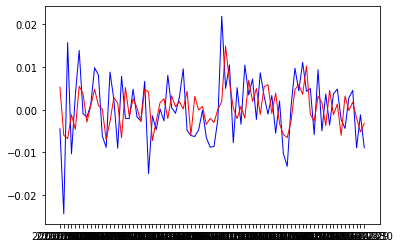

In [125]:
janelas = 80
plt.plot(MLP.target_train[-janelas:], 'b',linewidth=1.0) # plotting t, b separately
plt.plot(MLP.pred_train[-janelas:], 'r',  linewidth=1.0) # plotting t, a separately  
plt.show()

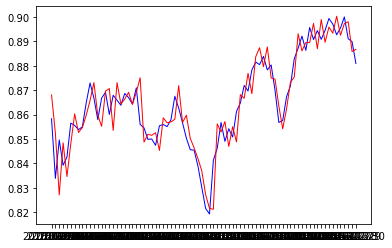

In [126]:
janelas = 80
plt.plot(MLP.target_train_undiff[-janelas:], 'b',linewidth=1.0) # plotting t, b separately
plt.plot(MLP.pred_train_undiff[-janelas:], 'r',  linewidth=1.0) # plotting t, a separately  
plt.show()

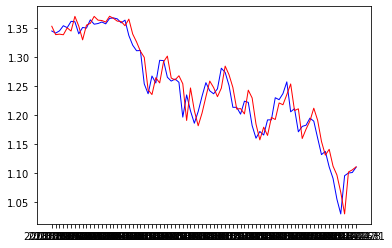

In [127]:
janelas = 80
plt.plot(MLP.target_valid_undiff[-janelas:], 'b',linewidth=1.0) # plotting t, b separately
plt.plot(MLP.pred_valid_undiff[-janelas:], 'r',  linewidth=1.0) # plotting t, a separately  
plt.show()

Epoch 1/5000
14/23 [=================>............] - ETA: 0s - loss: 1.7353e-04
Epoch 1: val_loss improved from inf to 0.00035, saving model to best_model.h5
23/23 [==============================] - 1s 15ms/step - loss: 1.7520e-04 - val_loss: 3.5002e-04
Epoch 2/5000
19/23 [=======================>......] - ETA: 0s - loss: 1.7200e-04
Epoch 2: val_loss improved from 0.00035 to 0.00035, saving model to best_model.h5
23/23 [==============================] - 0s 5ms/step - loss: 1.7582e-04 - val_loss: 3.4745e-04
Epoch 3/5000
20/23 [=========================>....] - ETA: 0s - loss: 1.7149e-04
Epoch 3: val_loss improved from 0.00035 to 0.00035, saving model to best_model.h5
23/23 [==============================] - 0s 5ms/step - loss: 1.7368e-04 - val_loss: 3.4625e-04
Epoch 4/5000
17/23 [=====================>........] - ETA: 0s - loss: 1.6975e-04
Epoch 4: val_loss did not improve from 0.00035
23/23 [==============================] - 0s 5ms/step - loss: 1.7350e-04 - val_loss: 3.4940e-04
Epoch 

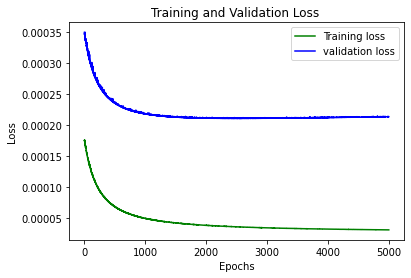

Train Resídual  Valid Resídual  Test Resídual      Train  \
IXIC                                                                          
MSE                      0.000030    2.135554e-04       0.000863   0.000030   
MAPE                     3.853854    3.004952e+10       2.243237   0.010734   
MAE                      0.004124    1.066613e-02       0.020256   0.004124   
RMSE                     0.005497    1.461354e-02       0.029379   0.005497   
POCID                   67.293233    5.079681e+01      49.504950  60.355434   
R2                       0.302769   -2.270128e-01      -0.158874   0.999254   
AVR                      2.162379    4.947541e+00       7.661112   0.000747   
Theil’s U1               0.532433    7.394545e-01       0.779145   0.005442   
Theil’s U2               0.340118    5.884036e-01       0.461424   0.695336   
Evaluate Function        9.147600    1.690437e-09       4.355286  35.360773   

                       Valid       Test  
IXIC                                     
MSE                 0.000214   0.000863  
MAPE                0.009225   0.013236  
MAE                 0.010666   0.020256  
RMSE                0.014614   0.029379  
POCID              50.398406  46.732673  
R2                  0.987243   0.989551  
AVR                 0.012680   0.010494  
Theil’s U1          0.006338   0.009291  
Theil’s U2          1.226357   1.151018  
Evaluate Function  22.414479  21.480254

In [113]:
MLP = MLP_Class(Indice="IXIC", epochs=5000, model_type = "MLP", timelag = 1350, diff=True,  batch_size= 128)
MLP.fit()
visualize_loss(MLP.history, "Training and Validation Loss ") 
# MLP.pap()
# visualize_loss(MLP.history, "Training and Validation Loss PAP") 
MLP.pred()
MLP.Save_Evaluate()

Epoch 1/5000
23/23 [==============================] - 0s 8ms/step - loss: 5.7118e-05 - val_loss: 2.1412e-04
Epoch 2/5000
23/23 [==============================] - 0s 5ms/step - loss: 5.7134e-05 - val_loss: 2.1361e-04
Epoch 3/5000
23/23 [==============================] - 0s 5ms/step - loss: 5.7103e-05 - val_loss: 2.1338e-04
Epoch 4/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.7154e-05 - val_loss: 2.1344e-04
Epoch 5/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.7052e-05 - val_loss: 2.1344e-04
Epoch 6/5000
23/23 [==============================] - 0s 6ms/step - loss: 5.7240e-05 - val_loss: 2.1331e-04
Epoch 7/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.6992e-05 - val_loss: 2.1355e-04
Epoch 8/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.6920e-05 - val_loss: 2.1335e-04
Epoch 9/5000
23/23 [==============================] - 0s 4ms/step - loss: 5.7020e-05 - val_loss: 2.1337e-04
Epoch 10/5000
23/23 [=======

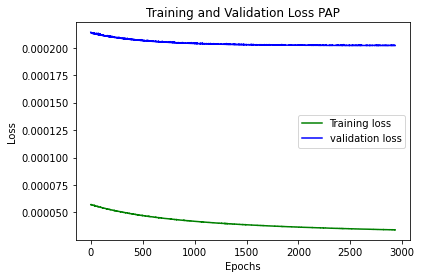

Train Resídual  Valid Resídual  Test Resídual      Train  \
IXIC                                                                          
MSE                      0.000043    2.020319e-04       0.000848   0.000043   
MAPE                     3.260792    2.698649e+10       1.964018   0.012328   
MAE                      0.004874    1.006266e-02       0.019681   0.004874   
RMSE                     0.006561    1.421379e-02       0.029117   0.006561   
POCID                   48.735475    4.760956e+01      40.594059  53.315106   
R2                       0.006768   -1.608027e-01      -0.138298   0.998938   
AVR                      3.936895    7.503908e+00      11.832116   0.001063   
Theil’s U1               0.661943    7.720949e-01       0.816007   0.006493   
Theil’s U2               0.485228    5.567335e-01       0.453231   0.991999   
Evaluate Function        5.612773    1.764200e-09       2.661868  26.585332   

                       Valid       Test  
IXIC                                     
MSE                 0.000202   0.000848  
MAPE                0.008662   0.013000  
MAE                 0.010063   0.019681  
RMSE                0.014214   0.029117  
POCID              49.601594  44.158416  
R2                  0.987932   0.989736  
AVR                 0.012000   0.010287  
Theil’s U1          0.006164   0.009206  
Theil’s U2          1.160350   1.130580  
Evaluate Function  22.740361  20.493849

In [124]:
MLP.pap()
visualize_loss(MLP.history, "Training and Validation Loss PAP") 
MLP.pred()
MLP.Save_Evaluate()

In [108]:
# Using plotly.express
import plotly.express as px
fig = px.line(MLP.target_train)
fig.show()

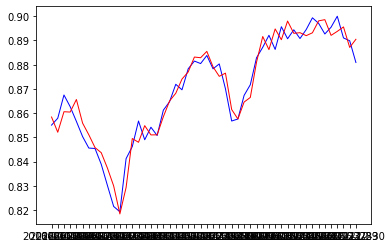

In [63]:
janelas = 50
plt.plot(MLP.target_train[-janelas:], 'b',linewidth=1.0) # plotting t, b separately
plt.plot(MLP.pred_train[-janelas:], 'r',  linewidth=1.0) # plotting t, a separately  
plt.show()

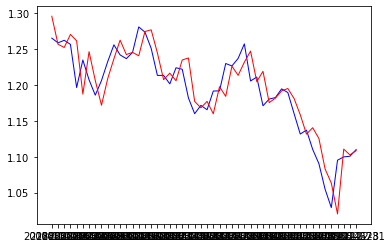

In [64]:
plt.plot(MLP.target_valid[-janelas:], 'b',linewidth=1.0) # plotting t, b separately
plt.plot(MLP.pred_valid[-janelas:], 'r',  linewidth=1.0) # plotting t, a separately  
plt.show()

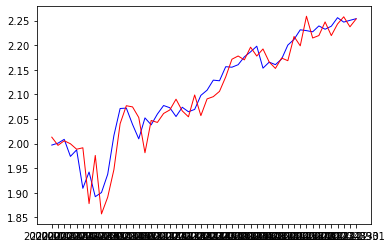

In [66]:
plt.plot(MLP.target_test[-janelas:], 'b',linewidth=1.0) # plotting t, b separately
plt.plot(MLP.pred_test[-janelas:], 'r',  linewidth=1.0) # plotting t, a separately  
plt.show()

### PAP

Epoch 1/10000
23/23 [==============================] - 0s 13ms/step - loss: 3.5827e-05 - val_loss: 2.0486e-04
Epoch 2/10000
23/23 [==============================] - 0s 7ms/step - loss: 3.5872e-05 - val_loss: 2.0491e-04
Epoch 3/10000
23/23 [==============================] - 0s 6ms/step - loss: 3.5845e-05 - val_loss: 2.0486e-04
Epoch 4/10000
23/23 [==============================] - 0s 6ms/step - loss: 3.5874e-05 - val_loss: 2.0492e-04
Epoch 5/10000
23/23 [==============================] - 0s 5ms/step - loss: 3.5824e-05 - val_loss: 2.0491e-04
Epoch 6/10000
23/23 [==============================] - 0s 5ms/step - loss: 3.5853e-05 - val_loss: 2.0490e-04
Epoch 7/10000
23/23 [==============================] - 0s 5ms/step - loss: 3.5842e-05 - val_loss: 2.0486e-04
Epoch 8/10000
23/23 [==============================] - 0s 5ms/step - loss: 3.5801e-05 - val_loss: 2.0490e-04
Epoch 9/10000
23/23 [==============================] - 0s 5ms/step - loss: 3.5834e-05 - val_loss: 2.0491e-04
Epoch 10/10000
23/

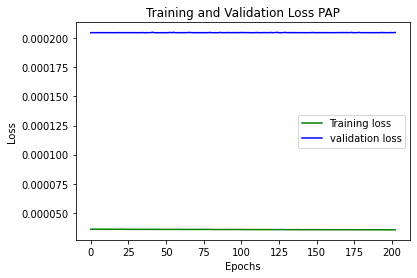

MSE: (Mean Squared Error) 4.326502572176028e-05
MAPE: (Mean Absolute Percentage Erro) 0.012444734945067426
MAE: Mean Absolute Error 0.0049114851893016466
RMSE: (Root Mean Square Error): 0.006577615504250783
POCID (Prediction of Change in Direction): 52.83663704716336
R2 (Coeficiente de Determinação): 0.9989324161477965
ARV (Average Relative Variance): 0.001067943927184008
Theil’s U1 : 0.006510867676228195
Theil’s U2 : 0.9970060645505574
Evaluate Function : 26.279536181992842
MSE: (Mean Squared Error) 0.00020485631729658381
MAPE: (Mean Absolute Percentage Erro) 0.008739061122287388
MAE: Mean Absolute Error 0.010095725719679732
RMSE: (Root Mean Square Error): 0.014312802566114849
POCID (Prediction of Change in Direction): 48.20717131474104
R2 (Coeficiente de Determinação): 0.9877629532720684
ARV (Average Relative Variance): 0.012109016232679147
Theil’s U1 : 0.006206602806705817
Theil’s U2 : 1.1757988811323934
Evaluate Function : 21.94375195899483
MSE: (Mean Squared Error) 0.0008673486662

((4.326502572176028e-05,
  0.012444734945067426,
  0.0049114851893016466,
  0.006577615504250783,
  52.83663704716336,
  0.9989324161477965,
  0.001067943927184008,
  0.006510867676228195,
  0.9970060645505574,
  26.279536181992842),
 (0.00020485631729658381,
  0.008739061122287388,
  0.010095725719679732,
  0.014312802566114849,
  48.20717131474104,
  0.9877629532720684,
  0.012109016232679147,
  0.006206602806705817,
  1.1757988811323934,
  21.94375195899483),
 (0.000867348666232805,
  0.013165858638555478,
  0.020043785800809115,
  0.0294507837965784,
  44.95049504950495,
  0.9894993370857441,
  0.010548299031883146,
  0.00931242586769725,
  1.1566327349873846,
  20.608014654360034))

In [52]:
MLP.pap()
visualize_loss(MLP.history, "Training and Validation Loss PAP") 
MLP.pred()
MLP.Save_Evaluate()

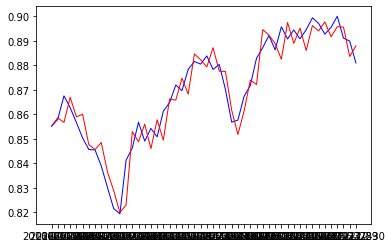

In [50]:
plt.plot(MLP.target_train[-janelas:], 'b',linewidth=1.0) # plotting t, b separately
plt.plot(MLP.pred_train[-janelas:], 'r',  linewidth=1.0) # plotting t, a separately  
plt.show()

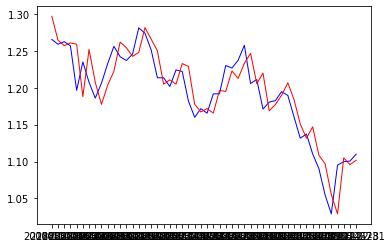

In [51]:
plt.plot(MLP.target_valid[-janelas:], 'b',linewidth=1.0) # plotting t, b separately
plt.plot(MLP.pred_valid[-janelas:], 'r',  linewidth=1.0) # plotting t, a separately  
plt.show()

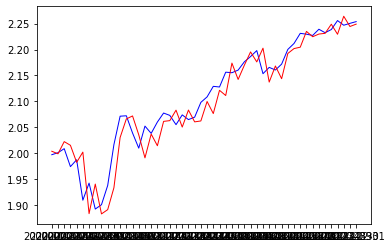

In [48]:
plt.plot(MLP.target_test[-janelas:], 'b',linewidth=1.0) # plotting t, b separately
plt.plot(MLP.pred_test[-janelas:], 'r',  linewidth=1.0) # plotting t, a separately  
plt.show()

Epoch 1/10000
22/23 [===========================>..] - ETA: 0s - loss: 1.7305e-04
Epoch 1: val_loss improved from inf to 0.00036, saving model to best_model.h5
23/23 [==============================] - 1s 19ms/step - loss: 1.7333e-04 - val_loss: 3.6026e-04
Epoch 2/10000
20/23 [=========================>....] - ETA: 0s - loss: 1.7070e-04
Epoch 2: val_loss did not improve from 0.00036
23/23 [==============================] - 0s 7ms/step - loss: 1.7111e-04 - val_loss: 3.6211e-04
Epoch 3/10000
19/23 [=======================>......] - ETA: 0s - loss: 1.6960e-04
Epoch 3: val_loss improved from 0.00036 to 0.00036, saving model to best_model.h5
23/23 [==============================] - 0s 8ms/step - loss: 1.6945e-04 - val_loss: 3.5691e-04
Epoch 4/10000
21/23 [==========================>...] - ETA: 0s - loss: 1.7063e-04
Epoch 4: val_loss did not improve from 0.00036
23/23 [==============================] - 0s 7ms/step - loss: 1.6937e-04 - val_loss: 3.5973e-04
Epoch 5/10000
23/23 [================

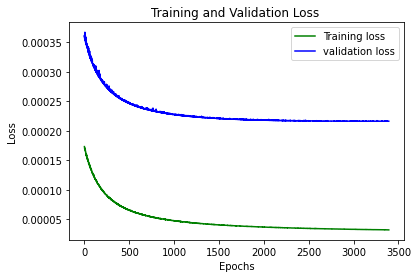

MSE: (Mean Squared Error) 3.2447955079085124e-05
MAPE: (Mean Absolute Percentage Erro) 3.4731000010897115
MAE: Mean Absolute Error 0.004317849214999581
RMSE: (Root Mean Square Error): 0.005696310655071853
POCID (Prediction of Change in Direction): 67.84005468215994
R2 (Coeficiente de Determinação): 0.2512460536350798
ARV (Average Relative Variance): 2.284321836374435
Theil’s U1 : 0.5498677317202699
Theil’s U2 : 0.3651623690861582
MSE: (Mean Squared Error) 0.00021622075882476774
MAPE: (Mean Absolute Percentage Erro) 20132686360.13376
MAE: Mean Absolute Error 0.010636242563263868
RMSE: (Root Mean Square Error): 0.014704446906455466
POCID (Prediction of Change in Direction): 49.800796812749006
R2 (Coeficiente de Determinação): -0.24232693617094858
ARV (Average Relative Variance): 5.049355716093937
Theil’s U1 : 0.7440912660728276
Theil’s U2 : 0.5956501285257502
MSE: (Mean Squared Error) 0.0008212326175872336
MAPE: (Mean Absolute Percentage Erro) 2.2902353894724183
MAE: Mean Absolute Error 

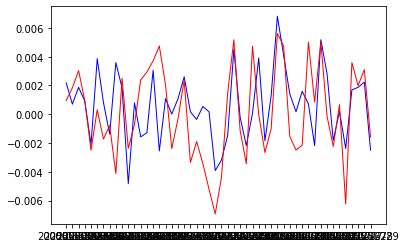

In [42]:
MLP = MLP_Class(Indice="IXIC", epochs=10000, model_type = "MLP", timelag = 1350, diff=True,  batch_size= 128)
MLP.fit()
visualize_loss(MLP.history, "Training and Validation Loss ") 
# MLP.pap()
# visualize_loss(MLP.history, "Training and Validation Loss PAP") 
MLP.pred()
MLP.Save_Evaluate()

janelas = 0 
janelas1 = 50

plt.plot(MLP.target_train[janelas:janelas1], 'b',linewidth=1.0) # plotting t, b separately
plt.plot(MLP.pred_train[janelas:janelas1], 'r',  linewidth=1.0) # plotting t, a separately  
plt.show()

Epoch 1/10000
23/27 [========================>.....] - ETA: 0s - loss: 1.7760e-04
Epoch 1: val_loss improved from inf to 0.00044, saving model to best_model.h5
27/27 [==============================] - 1s 16ms/step - loss: 1.7622e-04 - val_loss: 4.3954e-04
Epoch 2/10000
17/27 [=================>............] - ETA: 0s - loss: 1.7187e-04
Epoch 2: val_loss improved from 0.00044 to 0.00044, saving model to best_model.h5
27/27 [==============================] - 0s 5ms/step - loss: 1.7280e-04 - val_loss: 4.3836e-04
Epoch 3/10000
20/27 [=====================>........] - ETA: 0s - loss: 1.7560e-04
Epoch 3: val_loss did not improve from 0.00044
27/27 [==============================] - 0s 4ms/step - loss: 1.7195e-04 - val_loss: 4.3950e-04
Epoch 4/10000
19/27 [====================>.........] - ETA: 0s - loss: 1.7480e-04
Epoch 4: val_loss improved from 0.00044 to 0.00044, saving model to best_model.h5
27/27 [==============================] - 0s 5ms/step - loss: 1.7120e-04 - val_loss: 4.3747e-04
Ep

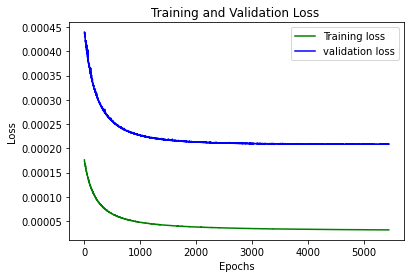

MSE: (Mean Squared Error) 3.198862627547693e-05
MAPE: (Mean Absolute Percentage Erro) 2.796373276159664
MAE: Mean Absolute Error 0.004186194264279704
RMSE: (Root Mean Square Error): 0.005655848855430716
POCID (Prediction of Change in Direction): 63.68943374197315
R2 (Coeficiente de Determinação): 0.1838525770132855
ARV (Average Relative Variance): 3.731212096141576
Theil’s U1 : 0.6133585021367207
Theil’s U2 : 0.3982608920857518
MSE: (Mean Squared Error) 0.00020859555418274817
MAPE: (Mean Absolute Percentage Erro) 24491416266.206974
MAE: Mean Absolute Error 0.010362579402027988
RMSE: (Root Mean Square Error): 0.014442837469927722
POCID (Prediction of Change in Direction): 48.40637450199203
R2 (Coeficiente de Determinação): -0.19851524495274364
ARV (Average Relative Variance): 7.042008915048613
Theil’s U1 : 0.7738973656083543
Theil’s U2 : 0.5745824386822173
MSE: (Mean Squared Error) 0.0008967840274158045
MAPE: (Mean Absolute Percentage Erro) 2.181194382374654
MAE: Mean Absolute Error 0.0

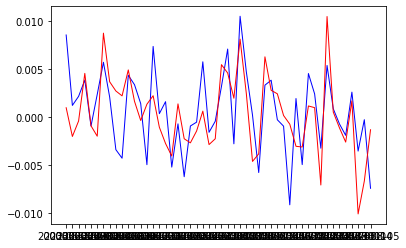

In [38]:
MLP = MLP_Class(Indice="IXIC", epochs=10000, model_type = "MLP", timelag = 1350, diff=True,  batch_size= 128)
MLP.fit()
visualize_loss(MLP.history, "Training and Validation Loss ") 
# MLP.pap()
# visualize_loss(MLP.history, "Training and Validation Loss PAP") 
MLP.pred()
MLP.Save_Evaluate()

janelas = 0 
janelas1 = 50

plt.plot(MLP.target_train[janelas:janelas1], 'b',linewidth=1.0) # plotting t, b separately
plt.plot(MLP.pred_train[janelas:janelas1], 'r',  linewidth=1.0) # plotting t, a separately  
plt.show()

Epoch 1/10000
89/94 [===========================>..] - ETA: 0s - loss: 3.9291e-04
Epoch 1: val_loss improved from inf to 0.00044, saving model to best_model.h5
94/94 [==============================] - 1s 6ms/step - loss: 3.9042e-04 - val_loss: 4.4269e-04
Epoch 2/10000
81/94 [========================>.....] - ETA: 0s - loss: 3.8915e-04
Epoch 2: val_loss improved from 0.00044 to 0.00041, saving model to best_model.h5
94/94 [==============================] - 0s 3ms/step - loss: 3.8342e-04 - val_loss: 4.1312e-04
Epoch 3/10000
82/94 [=========================>....] - ETA: 0s - loss: 3.7424e-04
Epoch 3: val_loss did not improve from 0.00041
94/94 [==============================] - 0s 3ms/step - loss: 3.7157e-04 - val_loss: 4.2823e-04
Epoch 4/10000
87/94 [==========================>...] - ETA: 0s - loss: 3.6229e-04
Epoch 4: val_loss improved from 0.00041 to 0.00041, saving model to best_model.h5
94/94 [==============================] - 0s 3ms/step - loss: 3.6288e-04 - val_loss: 4.0534e-04
Epo

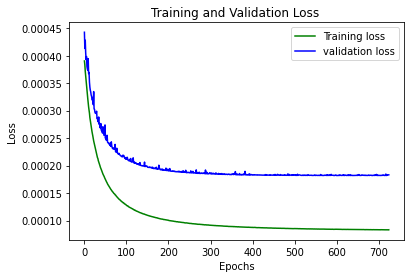

MSE: (Mean Squared Error) 8.369724745467177e-05
MAPE: (Mean Absolute Percentage Erro) 2.4279210295239353
MAE: Mean Absolute Error 0.006529791595660755
RMSE: (Root Mean Square Error): 0.00914861997542098
POCID (Prediction of Change in Direction): 58.05643680080147
R2 (Coeficiente de Determinação): 0.11096429610657554
ARV (Average Relative Variance): 6.900570701909555
Theil’s U1 : 0.6936251276045817
Theil’s U2 : 0.4448689139976529
MSE: (Mean Squared Error) 0.0001820253213608034
MAPE: (Mean Absolute Percentage Erro) 19757582313.987984
MAE: Mean Absolute Error 0.009329130144384025
RMSE: (Root Mean Square Error): 0.013491676002661915
POCID (Prediction of Change in Direction): 48.20717131474104
R2 (Coeficiente de Determinação): -0.04585221613696322
ARV (Average Relative Variance): 15.829830117063446
Theil’s U1 : 0.8115949996233073
Theil’s U2 : 0.5009233569579139
MSE: (Mean Squared Error) 0.0008075811255488762
MAPE: (Mean Absolute Percentage Erro) 1.9826546244447663
MAE: Mean Absolute Error 0

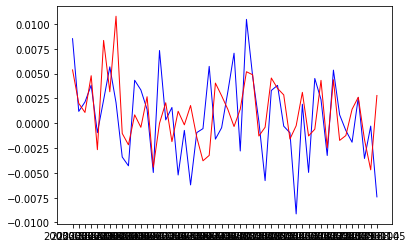

In [36]:
MLP = MLP_Class(Indice="IXIC", epochs=10000, model_type = "MLP", timelag = 850, diff=True,  batch_size= 128)
MLP.fit()
visualize_loss(MLP.history, "Training and Validation Loss ") 
# MLP.pap()
# visualize_loss(MLP.history, "Training and Validation Loss PAP") 
MLP.pred()
MLP.Save_Evaluate()

janelas = 0 
janelas1 = 50

plt.plot(MLP.target_train[janelas:janelas1], 'b',linewidth=1.0) # plotting t, b separately
plt.plot(MLP.pred_train[janelas:janelas1], 'r',  linewidth=1.0) # plotting t, a separately  
plt.show()

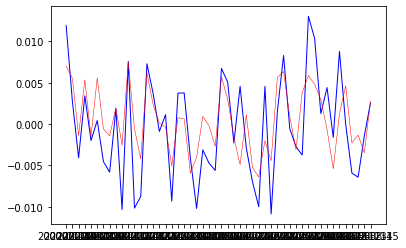

In [19]:
janelas = 0 
janelas1 = 50

plt.plot(MLP.target_train[janelas:janelas1], 'b',linewidth=1.0) # plotting t, b separately
plt.plot(MLP.pred_train[janelas:janelas1], 'r',  linewidth=0.5) # plotting t, a separately  
plt.show()

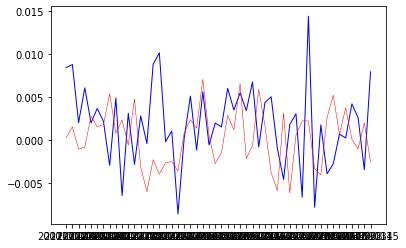

In [20]:
janelas = 0 
janelas1 = 50
plt.plot(MLP.target_valid[janelas:janelas1], 'b',linewidth=1) # plotting t, b separately
plt.plot(MLP.pred_valid[janelas:janelas1], 'r',linewidth=0.5) # plotting t, a separately  
plt.show()

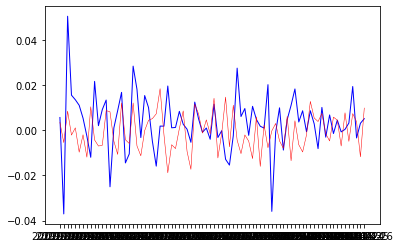

In [46]:
janelas = 0 
janelas1 = 80 
plt.plot(MLP.target_test[janelas:janelas1], 'b',linewidth=1) # plotting t, b separately
plt.plot(MLP.pred_test[janelas:janelas1], 'r',linewidth=0.5) # plotting t, a separately  
plt.show()

Epoch 1/300
118/120 [============================>.] - ETA: 0s - loss: 1.5433
Epoch 1: val_loss improved from inf to 1.82844, saving model to best_model.h5
120/120 [==============================] - 1s 5ms/step - loss: 1.5370 - val_loss: 1.8284
Epoch 2/300
120/120 [==============================] - ETA: 0s - loss: 1.4950
Epoch 2: val_loss improved from 1.82844 to 1.78389, saving model to best_model.h5
120/120 [==============================] - 0s 3ms/step - loss: 1.4950 - val_loss: 1.7839
Epoch 3/300
117/120 [============================>.] - ETA: 0s - loss: 1.4701
Epoch 3: val_loss improved from 1.78389 to 1.75382, saving model to best_model.h5
120/120 [==============================] - 0s 3ms/step - loss: 1.4646 - val_loss: 1.7538
Epoch 4/300
110/120 [==========================>...] - ETA: 0s - loss: 1.4530
Epoch 4: val_loss improved from 1.75382 to 1.73386, saving model to best_model.h5
120/120 [==============================] - 0s 3ms/step - loss: 1.4432 - val_loss: 1.7339
Epoch 5/

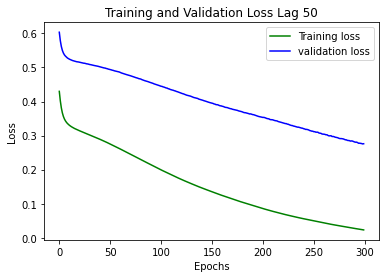

(0.00010215042191358281, 1358290414.5317132, 0.006135648822915832, 0.010106949189225342, 61.887014515496276, 0.28075971606450256, 6.311171952954684, 0.6334364392339284, 0.32524686533053915)
(0.00013179825758771548, 45565792642.908775, 0.008187444052671175, 0.011480342224329181, 60.67864271457086, 0.24369464222800152, 5.882763688667459, 0.6392683517010159, 0.3623436745397384)
(0.0005343588589389859, 1.5321149999281396, 0.01411694018796028, 0.023116203385049758, 76.78571428571429, 0.2839299721023286, 10.573641297103961, 0.669211362964798, 0.28564390338895407)
Epoch 1/300
111/118 [===========================>..] - ETA: 0s - loss: 1.6443
Epoch 1: val_loss improved from inf to 2.00931, saving model to best_model.h5
118/118 [==============================] - 1s 5ms/step - loss: 1.6424 - val_loss: 2.0093
Epoch 2/300
117/118 [============================>.] - ETA: 0s - loss: 1.5503
Epoch 2: val_loss improved from 2.00931 to 1.93324, saving model to best_model.h5
118/118 [======================

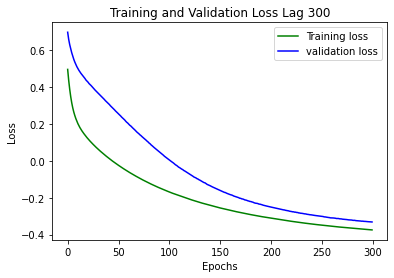

(6.86460482971186e-05, 97160214.54495718, 0.0035157921803915387, 0.008285291081013304, 85.72852964637065, 0.5018862365163778, 2.4613478214864477, 0.48635813754206564, 0.22427188871144793)
(7.17749005200717e-05, 1017421285.579782, 0.004256295664151131, 0.008472006876771979, 92.01596806387225, 0.5881300495891985, 1.780534889833228, 0.43244618968243365, 0.19739477353231033)
(0.00047556396589662443, 0.37917836560441626, 0.010732910285143064, 0.021807429144597133, 93.65079365079364, 0.3627183368815332, 6.974568734566639, 0.6084265365439964, 0.2542305263973596)
Epoch 1/300
116/116 [==============================] - ETA: 0s - loss: 1.7050
Epoch 1: val_loss improved from inf to 1.92907, saving model to best_model.h5
116/116 [==============================] - 1s 5ms/step - loss: 1.7050 - val_loss: 1.9291
Epoch 2/300
109/116 [===========================>..] - ETA: 0s - loss: 1.6104
Epoch 2: val_loss improved from 1.92907 to 1.84033, saving model to best_model.h5
116/116 [========================

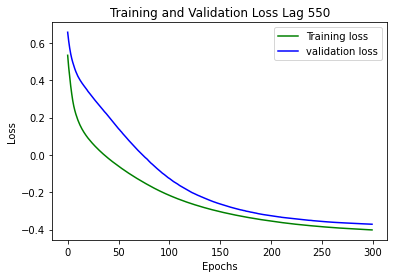

(6.6834961610734e-05, 49482639.98329887, 0.00295447888286832, 0.008175265231827895, 91.78045153440584, 0.5203288254224292, 2.211906524541679, 0.4720939224472019, 0.215284761673285)
(6.896932025291003e-05, 908466049.8141954, 0.003671926899609732, 0.008304776953832657, 96.20758483033931, 0.6042294687055825, 1.585020731985378, 0.4184360876771126, 0.1896776399542246)
(0.0004738740438321696, 0.36311547126769256, 0.010589141342245768, 0.021768648185685982, 94.04761904761905, 0.3649829246573245, 7.0534106845921505, 0.6081454720459395, 0.253326902960475)
Epoch 1/300
109/114 [===========================>..] - ETA: 0s - loss: 1.7413
Epoch 1: val_loss improved from inf to 1.99354, saving model to best_model.h5
114/114 [==============================] - 1s 5ms/step - loss: 1.7384 - val_loss: 1.9935
Epoch 2/300
111/114 [============================>.] - ETA: 0s - loss: 1.5945
Epoch 2: val_loss improved from 1.99354 to 1.86540, saving model to best_model.h5
114/114 [==============================] -

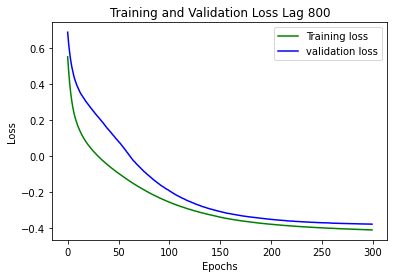

(6.625893724757645e-05, 35306202.853577875, 0.0027200389129967326, 0.008139959290289876, 94.74009900990099, 0.5283514299508864, 2.090258959174791, 0.4651248342874544, 0.21190809380727174)
(6.846582232738075e-05, 1922864175.4780912, 0.003532061339325856, 0.008274407672297803, 96.20758483033931, 0.6071187191833549, 1.5728541052914244, 0.4168141811268992, 0.1882941724565735)
(0.0004744769168573803, 0.3471218993696795, 0.010601092111030637, 0.02178249106179962, 96.82539682539682, 0.36417504190819494, 7.079042495441363, 0.6083316291059879, 0.2536493393003111)
Epoch 1/300
110/112 [============================>.] - ETA: 0s - loss: 1.7558
Epoch 1: val_loss improved from inf to 1.95323, saving model to best_model.h5
112/112 [==============================] - 1s 4ms/step - loss: 1.7505 - val_loss: 1.9532
Epoch 2/300
107/112 [===========================>..] - ETA: 0s - loss: 1.6052
Epoch 2: val_loss improved from 1.95323 to 1.83267, saving model to best_model.h5
112/112 [=========================

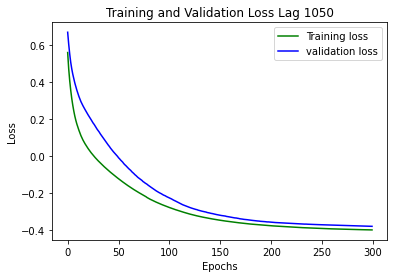

(6.714222682979009e-05, 27861388.343108878, 0.002568947226900141, 0.00819403605250734, 96.6839233244718, 0.5307524093001168, 2.042298241318784, 0.4626125978009883, 0.21088616916736674)
(6.848577700980973e-05, 1107463562.8803623, 0.003524267295189843, 0.008275613391755908, 96.40718562874252, 0.6070042121063275, 1.5615455903465025, 0.41639349180114904, 0.1883483471614119)
(0.0004737742104988853, 0.3460283991766084, 0.010535844344741922, 0.021766355011781032, 97.02380952380952, 0.36511670677126196, 7.07627217606459, 0.6082452802918534, 0.25327376233169)
Epoch 1/300
108/110 [============================>.] - ETA: 0s - loss: 1.7696
Epoch 1: val_loss improved from inf to 1.86167, saving model to best_model.h5
110/110 [==============================] - 1s 5ms/step - loss: 1.7667 - val_loss: 1.8617
Epoch 2/300
106/110 [===========================>..] - ETA: 0s - loss: 1.5785
Epoch 2: val_loss improved from 1.86167 to 1.73134, saving model to best_model.h5
110/110 [=============================

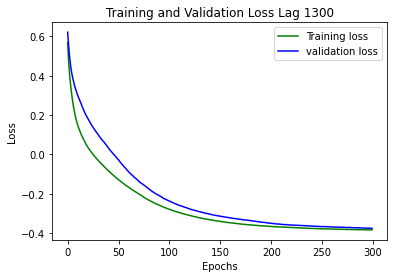

(6.812522055544106e-05, 56364581.9255733, 0.0025171160773248815, 0.008253800370462146, 97.35118199943035, 0.5313686530236801, 2.0163565284089078, 0.46142307028998986, 0.21037913160688682)
(6.867484710655274e-05, 3145229089.661829, 0.003540124971010384, 0.00828702884673106, 96.40718562874252, 0.605919260531258, 1.582037711054273, 0.4176427093286991, 0.18886903089873586)
(0.0004737795857362041, 0.32932590873879175, 0.010538590665476834, 0.021766478487256595, 96.62698412698413, 0.36510950365995865, 7.06201964095109, 0.6079331066714784, 0.25327662935146505)
Epoch 1/300
103/108 [===========================>..] - ETA: 0s - loss: 1.8084
Epoch 1: val_loss improved from inf to 1.94800, saving model to best_model.h5
108/108 [==============================] - 1s 7ms/step - loss: 1.8250 - val_loss: 1.9480
Epoch 2/300
 97/108 [=========================>....] - ETA: 0s - loss: 1.6495
Epoch 2: val_loss improved from 1.94800 to 1.79382, saving model to best_model.h5
108/108 [==========================

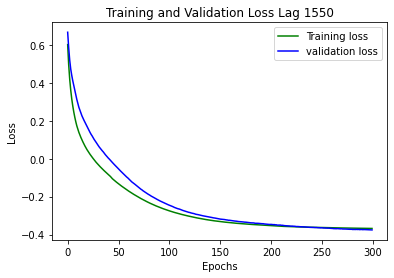

(6.918868235111268e-05, 45184910.53743963, 0.002492403288632882, 0.008317973452176478, 97.868638538495, 0.5315189756203316, 1.992967117856161, 0.46049542084078005, 0.21028244111136563)
(6.867642893576507e-05, 356471986.2203382, 0.0035566491649130752, 0.008287124286250634, 96.20758483033931, 0.6059101834316796, 1.580711385874306, 0.4176128840952535, 0.18887288892339651)
(0.00047385909822726153, 0.3347220539454335, 0.010541214005015401, 0.0217683049001814, 96.62698412698413, 0.365002952583398, 7.078419963992559, 0.6081562935502721, 0.2533191428508548)
Epoch 1/300
 97/106 [==========================>...] - ETA: 0s - loss: 1.8640
Epoch 1: val_loss improved from inf to 1.91755, saving model to best_model.h5
106/106 [==============================] - 1s 5ms/step - loss: 1.8485 - val_loss: 1.9175
Epoch 2/300
 97/106 [==========================>...] - ETA: 0s - loss: 1.6467
Epoch 2: val_loss improved from 1.91755 to 1.76095, saving model to best_model.h5
106/106 [==============================

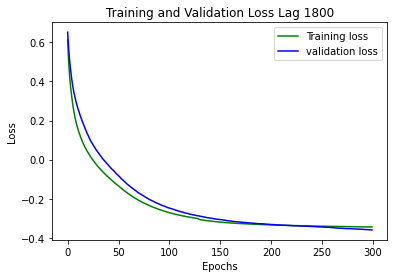

(7.087800533516973e-05, 68030974.86483914, 0.002510541026224832, 0.00841890760937366, 97.62256349675133, 0.5293000907378876, 1.993637285144978, 0.4612520579838079, 0.2110953934061457)
(6.983794641770774e-05, 1624535539.1182954, 0.0036360408803122173, 0.008356910099893844, 96.20758483033931, 0.5992449823067373, 1.5898980172504675, 0.42026681170516966, 0.19206737385535902)
(0.00047446282902634365, 0.3355432768293029, 0.010562345988277948, 0.02178216768428578, 96.23015873015873, 0.3641939203704767, 7.0966326077911495, 0.6087836421864057, 0.25364182476053715)
Epoch 1/300
104/104 [==============================] - ETA: 0s - loss: 1.8471
Epoch 1: val_loss improved from inf to 1.89783, saving model to best_model.h5
104/104 [==============================] - 1s 5ms/step - loss: 1.8471 - val_loss: 1.8978
Epoch 2/300
 90/104 [========================>.....] - ETA: 0s - loss: 1.6599
Epoch 2: val_loss improved from 1.89783 to 1.74752, saving model to best_model.h5
104/104 [========================

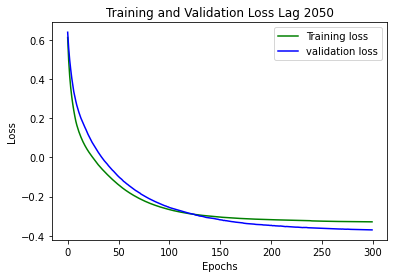

(7.192563102410208e-05, 11793406.631430287, 0.0025290915345118565, 0.008480898008118132, 97.94644200391154, 0.5284011642265494, 2.000500972672063, 0.46179520660951046, 0.21143617358256087)
(6.904007853781311e-05, 1268085235.1925793, 0.0035915283064774242, 0.008309035957186196, 95.60878243512974, 0.6038234324577714, 1.5771161295943974, 0.4181232642517636, 0.18987211655597105)
(0.0004766713842281772, 0.33795460077754697, 0.010628375194008423, 0.021832805230390738, 95.83333333333334, 0.3612343358917416, 7.163047117064975, 0.6101051852554902, 0.2548225596097821)
Epoch 1/300
 95/102 [==========================>...] - ETA: 0s - loss: 1.9060
Epoch 1: val_loss improved from inf to 1.97558, saving model to best_model.h5
102/102 [==============================] - 1s 7ms/step - loss: 1.8961 - val_loss: 1.9756
Epoch 2/300
 96/102 [===========================>..] - ETA: 0s - loss: 1.6933
Epoch 2: val_loss improved from 1.97558 to 1.80093, saving model to best_model.h5
102/102 [=====================

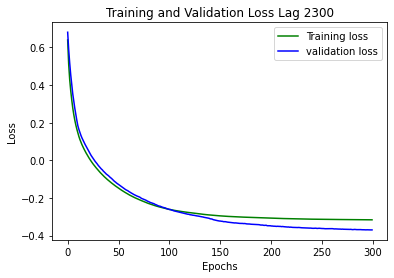

(7.28853827007484e-05, 29798301.072340034, 0.002532040161382899, 0.008537293640302436, 97.95308187672494, 0.5262822036693701, 2.0288490726675987, 0.46353046114765484, 0.21253040924591474)
(6.910550528144687e-05, 1291158354.8463326, 0.003592553377594642, 0.008312972108785574, 95.20958083832335, 0.6034479904932304, 1.582244017637424, 0.4184721334983145, 0.19005334090118192)
(0.00047411636041537524, 0.49205399983130216, 0.010551313791837054, 0.021774213198537742, 97.02380952380952, 0.3646582072139932, 7.093087774688554, 0.608586923690327, 0.2534566766101551)
Epoch 1/300
 99/100 [============================>.] - ETA: 0s - loss: 1.8753
Epoch 1: val_loss improved from inf to 1.81428, saving model to best_model.h5
100/100 [==============================] - 1s 7ms/step - loss: 1.8747 - val_loss: 1.8143
Epoch 2/300
 96/100 [===========================>..] - ETA: 0s - loss: 1.6781
Epoch 2: val_loss improved from 1.81428 to 1.66424, saving model to best_model.h5
100/100 [========================

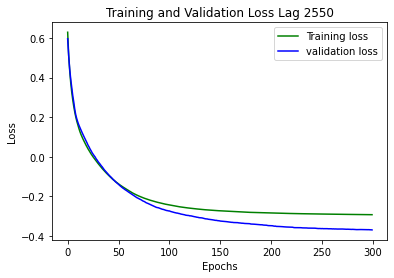

(7.465861484820496e-05, 74181015.8125284, 0.002606802748780774, 0.008640521676855221, 97.53790839455995, 0.5215683526407238, 2.0438958201027324, 0.4656309629763496, 0.21466129651541033)
(6.916265802481175e-05, 4979670681.29963, 0.003588565852272924, 0.008316408962094863, 96.00798403193613, 0.6031200276900086, 1.5852450426776978, 0.4186875816205191, 0.19020959875735777)
(0.000474701234308912, 0.3362165423727565, 0.010588271615755282, 0.021787639484554356, 95.83333333333334, 0.36387444428341675, 7.1132174025398065, 0.6088313450079249, 0.25376924491534664)
Epoch 1/300
91/98 [==========================>...] - ETA: 0s - loss: 1.9214
Epoch 1: val_loss improved from inf to 1.87078, saving model to best_model.h5
98/98 [==============================] - 1s 6ms/step - loss: 1.9002 - val_loss: 1.8708
Epoch 2/300
90/98 [==========================>...] - ETA: 0s - loss: 1.6899
Epoch 2: val_loss improved from 1.87078 to 1.70359, saving model to best_model.h5
98/98 [==============================] - 

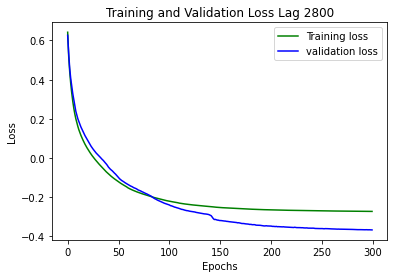

(7.615664864591329e-05, 46355733.57709142, 0.002665414549908133, 0.008726777678267808, 97.54464285714286, 0.5206288685775595, 2.0543427553111435, 0.46635168265820576, 0.21476210275423746)
(6.931616567306748e-05, 632442218.3007759, 0.0036247224240009528, 0.008325633049388345, 95.20958083832335, 0.602239146114184, 1.5743660125180527, 0.41854530651321514, 0.1906317621552516)
(0.0004757583754382893, 0.41030552368469786, 0.010657074815275986, 0.021811886104559808, 95.63492063492063, 0.36245781748788086, 7.026086631727788, 0.6092382083820131, 0.2542875861504625)


In [449]:
result = []
for e in range(50,3000,250):
    MLP = MLP_Class(Indice="IXIC", epochs=300, model_type = "MLP", timelag = e,  batch_size= 128)
    MLP.fit()
    MLP.pred()
    MLP.Save_Evaluate() 
    
    visualize_loss(MLP.history, "Training and Validation Loss " +"Lag "+str(e)) 
    result.append((MLP.eval_train, MLP.eval_valid, MLP.eval_test))
    print(MLP.eval_train)
    print(MLP.eval_valid)
    print(MLP.eval_test)
    
RW_train = pd.DataFrame(index= ["MSE", "MAPE","MAE","RMSE", "POCID", "R2 ", "AVR", "Theil’s U1", "Theil’s U2"])
RW_train.index.name = "Train"
for e, p in zip(range(0, len(result)), range(50,3000,250)):
    RW_train[str(p)] = result[e][0]
    
RW_valid = pd.DataFrame(index= ["MSE", "MAPE","MAE","RMSE", "POCID", "R2 ", "AVR", "Theil’s U1", "Theil’s U2"])
RW_valid.index.name = "Valid"
for e, p in zip(range(0, len(result)), range(50,3000,250)):
    RW_valid[str(p)] = result[e][1]
    
RW_test = pd.DataFrame(index= ["MSE", "MAPE","MAE","RMSE", "POCID", "R2 ", "AVR", "Theil’s U1", "Theil’s U2"])
RW_test.index.name = "Test"
for e, p in zip(range(0, len(result)), range(50,3000,250)):
    RW_test[str(p)] = result[e][2]
RW_train = RW_train.transpose()
RW_valid = RW_valid.transpose()
RW_test = RW_test.transpose()

In [504]:
RW_train

Train       MSE          MAPE       MAE      RMSE      POCID       R2   \
50     0.000102  1.358290e+09  0.006136  0.010107  61.887015  0.280760   
300    0.000069  9.716021e+07  0.003516  0.008285  85.728530  0.501886   
550    0.000067  4.948264e+07  0.002954  0.008175  91.780452  0.520329   
800    0.000066  3.530620e+07  0.002720  0.008140  94.740099  0.528351   
1050   0.000067  2.786139e+07  0.002569  0.008194  96.683923  0.530752   
1300   0.000068  5.636458e+07  0.002517  0.008254  97.351182  0.531369   
1550   0.000069  4.518491e+07  0.002492  0.008318  97.868639  0.531519   
1800   0.000071  6.803097e+07  0.002511  0.008419  97.622563  0.529300   
2050   0.000072  1.179341e+07  0.002529  0.008481  97.946442  0.528401   
2300   0.000073  2.979830e+07  0.002532  0.008537  97.953082  0.526282   
2550   0.000075  7.418102e+07  0.002607  0.008641  97.537908  0.521568   
2800   0.000076  4.635573e+07  0.002665  0.008727  97.544643  0.520629   

Train       AVR  Theil’s U1  Theil’s U2  
50     6.311172    0.633436    0.325247  
300    2.461348    0.486358    0.224272  
550    2.211907    0.472094    0.215285  
800    2.090259    0.465125    0.211908  
1050   2.042298    0.462613    0.210886  
1300   2.016357    0.461423    0.210379  
1550   1.992967    0.460495    0.210282  
1800   1.993637    0.461252    0.211095  
2050   2.000501    0.461795    0.211436  
2300   2.028849    0.463530    0.212530  
2550   2.043896    0.465631    0.214661  
2800   2.054343    0.466352    0.214762

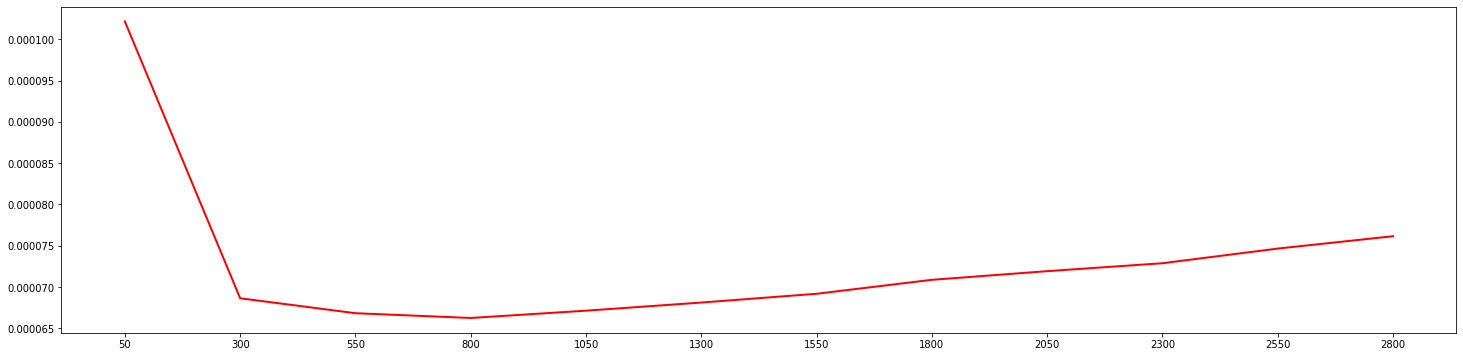

In [511]:
RW_train["POCID"]

plt.figure(figsize=(25,6))
plt.plot(RW_train["MSE"], 'r', linewidth=2) # plotting t, b separately
plt.plot(RW_train["MAPE"], 'r', linewidth=2) # plotting t, b separately
plt.plot(RW_train["MAE"], 'r', linewidth=2) # plotting t, b separately
plt.plot(RW_train["RMSE"], 'r', linewidth=2) # plotting t, b separately
plt.plot(RW_train["POCID"]/100, 'b', linewidth=2) # plotting t, b separately
plt.plot(RW_train["Theil’s U2"], 'r', linewidth=2) # plotting t, b separately
plt.show()

In [512]:
RW_valid

Valid       MSE          MAPE       MAE      RMSE      POCID       R2   \
50     0.000132  4.556579e+10  0.008187  0.011480  60.678643  0.243695   
300    0.000072  1.017421e+09  0.004256  0.008472  92.015968  0.588130   
550    0.000069  9.084660e+08  0.003672  0.008305  96.207585  0.604229   
800    0.000068  1.922864e+09  0.003532  0.008274  96.207585  0.607119   
1050   0.000068  1.107464e+09  0.003524  0.008276  96.407186  0.607004   
1300   0.000069  3.145229e+09  0.003540  0.008287  96.407186  0.605919   
1550   0.000069  3.564720e+08  0.003557  0.008287  96.207585  0.605910   
1800   0.000070  1.624536e+09  0.003636  0.008357  96.207585  0.599245   
2050   0.000069  1.268085e+09  0.003592  0.008309  95.608782  0.603823   
2300   0.000069  1.291158e+09  0.003593  0.008313  95.209581  0.603448   
2550   0.000069  4.979671e+09  0.003589  0.008316  96.007984  0.603120   
2800   0.000069  6.324422e+08  0.003625  0.008326  95.209581  0.602239   

Valid       AVR  Theil’s U1  Theil’s U2  
50     5.882764    0.639268    0.362344  
300    1.780535    0.432446    0.197395  
550    1.585021    0.418436    0.189678  
800    1.572854    0.416814    0.188294  
1050   1.561546    0.416393    0.188348  
1300   1.582038    0.417643    0.188869  
1550   1.580711    0.417613    0.188873  
1800   1.589898    0.420267    0.192067  
2050   1.577116    0.418123    0.189872  
2300   1.582244    0.418472    0.190053  
2550   1.585245    0.418688    0.190210  
2800   1.574366    0.418545    0.190632

In [513]:
RW_test

Test       MSE      MAPE       MAE      RMSE      POCID       R2         AVR  \
50    0.000534  1.532115  0.014117  0.023116  76.785714  0.283930  10.573641   
300   0.000476  0.379178  0.010733  0.021807  93.650794  0.362718   6.974569   
550   0.000474  0.363115  0.010589  0.021769  94.047619  0.364983   7.053411   
800   0.000474  0.347122  0.010601  0.021782  96.825397  0.364175   7.079042   
1050  0.000474  0.346028  0.010536  0.021766  97.023810  0.365117   7.076272   
1300  0.000474  0.329326  0.010539  0.021766  96.626984  0.365110   7.062020   
1550  0.000474  0.334722  0.010541  0.021768  96.626984  0.365003   7.078420   
1800  0.000474  0.335543  0.010562  0.021782  96.230159  0.364194   7.096633   
2050  0.000477  0.337955  0.010628  0.021833  95.833333  0.361234   7.163047   
2300  0.000474  0.492054  0.010551  0.021774  97.023810  0.364658   7.093088   
2550  0.000475  0.336217  0.010588  0.021788  95.833333  0.363874   7.113217   
2800  0.000476  0.410306  0.010657  0.021812  95.634921  0.362458   7.026087   

Test  Theil’s U1  Theil’s U2  
50      0.669211    0.285644  
300     0.608427    0.254231  
550     0.608145    0.253327  
800     0.608332    0.253649  
1050    0.608245    0.253274  
1300    0.607933    0.253277  
1550    0.608156    0.253319  
1800    0.608784    0.253642  
2050    0.610105    0.254823  
2300    0.608587    0.253457  
2550    0.608831    0.253769  
2800    0.609238    0.254288

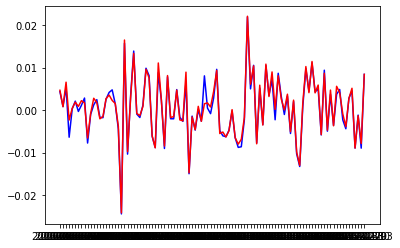

In [ ]:
janelas = 1377 
janelas1 = 1477 

plt.plot(MLP.target_train[janelas:janelas1], 'b') # plotting t, b separately
plt.plot(MLP.pred_train[janelas:janelas1], 'r') # plotting t, a separately  
plt.show()

In [ ]:
MLP.target_valid

Target Valid
Date                    
2017-01-04      0.008766
2017-01-05      0.002001
2017-01-06      0.006059
2017-01-09      0.001968
2017-01-10      0.003659
...                  ...
2018-12-26      0.066117
2018-12-27      0.004597
2018-12-28      0.000920
2018-12-31      0.009285
2019-01-02      0.005609

[502 rows x 1 columns]

In [ ]:
MLP.pred_valid

Predicted Valid
Date                       
2017-01-04         0.003171
2017-01-05         0.005870
2017-01-06        -0.008476
2017-01-09         0.000186
2017-01-10         0.003156
...                     ...
2018-12-26        -0.007041
2018-12-27         0.000104
2018-12-28         0.002070
2018-12-31         0.005233
2019-01-02         0.001196

[502 rows x 1 columns]

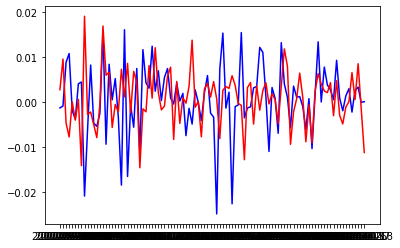

In [ ]:
janelas = 100 
janelas1 = 200 
plt.plot(MLP.target_valid[janelas:janelas1], 'b') # plotting t, b separately
plt.plot(MLP.pred_valid[janelas:janelas1], 'r') # plotting t, a separately  
plt.show()

In [ ]:
MLP_result = []
for indice in Indices:    
    MLP = MLP_Class(Indice=indice, epochs=10, model_type = "MLP", year= None,  batch_size= None)
    MLP.fit()
    MLP.pred()    
    MLP_result.append(MLP.Save_Evaluate())

                 0         1         2         3         4         5    \
Date                                                                     
2003-05-07 -1.325024  0.483836 -0.169466  0.248058  0.875572 -0.551377   
2003-05-08  0.483836 -0.169466  0.248058  0.875572 -0.551377  0.054032   
2003-05-09 -0.169466  0.248058  0.875572 -0.551377  0.054032  0.836275   
2003-05-12  0.248058  0.875572 -0.551377  0.054032  0.836275  0.442084   
2003-05-13  0.875572 -0.551377  0.054032  0.836275  0.442084  0.485064   
...              ...       ...       ...       ...       ...       ...   
2016-12-23 -0.943112 -1.641851 -0.276302  0.067541  0.105609  2.243576   
2016-12-26 -1.641851 -0.276302  0.067541  0.105609  2.243576 -0.256654   
2016-12-27 -0.276302  0.067541  0.105609  2.243576 -0.256654  0.110521   
2016-12-28  0.067541  0.105609  2.243576 -0.256654  0.110521  0.781015   
2016-12-29  0.105609  2.243576 -0.256654  0.110521  0.781015  1.715531   

                 6         7         

In [ ]:
panadsd = []
for e in range(0,(6)):
    RW = pd.DataFrame(index= ["MSE", "MAPE","MAE","RMSE", "POCID", "R2 ", "AVR", "Theil’s U1", "Theil’s U2"])
    RW["Train"] = MLP_result[e][0]
    RW["Valid"] = MLP_result[e][1]
    RW["Test"] = MLP_result[e][2]
    RW.index.name= Indices[e]
    panadsd.append(RW)

In [ ]:
panadsd[0]

Train         Valid       Test
BVSP                                             
MSE         2.312197e-01  2.046087e+00   5.939306
MAPE        1.531803e+12  1.410669e+13   2.611019
MAE         3.477861e-01  1.077585e+00   1.762481
RMSE        4.808531e-01  1.430415e+00   2.437069
POCID       8.509317e+01  4.898374e+01  51.686910
R2          7.780226e-01 -3.712690e-01  -0.248910
AVR         2.054870e-01  4.072835e+00   4.455190
Theil’s U1  2.312629e-01  7.492790e-01   0.731773
Theil’s U2  1.089333e-01  6.649723e-01   0.526113

In [ ]:
panadsd[1]

Train         Valid       Test
IXIC                                             
MSE         2.122003e-01  1.958417e+00   6.164568
MAPE        1.524984e+12  9.983913e+12   2.955736
MAE         3.272611e-01  1.057640e+00   1.801347
RMSE        4.606520e-01  1.399434e+00   2.482855
POCID       8.237371e+01  4.918699e+01  48.852901
R2          7.795312e-01 -3.125131e-01  -0.296277
AVR         2.322633e-01  5.358233e+00   4.578399
Theil’s U1  2.378089e-01  7.673808e-01   0.743359
Theil’s U2  1.081743e-01  6.403758e-01   0.546002

In [ ]:
panadsd[2]

Train         Valid       Test
DJI                                              
MSE         2.049796e-01  1.863949e+00   5.863396
MAPE        1.499373e+12  8.971122e+12   3.203184
MAE         3.239210e-01  1.024452e+00   1.728079
RMSE        4.527467e-01  1.365265e+00   2.421445
POCID       8.320947e+01  4.939024e+01  53.441296
R2          7.896339e-01 -2.492017e-01  -0.232947
AVR         2.423171e-01  6.195775e+00   4.887369
Theil’s U1  2.373948e-01  7.735943e-01   0.739114
Theil’s U2  1.032832e-01  6.094580e-01   0.519611

In [ ]:
panadsd[3]

Train         Valid       Test
FCHI                                             
MSE         1.665584e+00  2.521039e+00  10.048538
MAPE        6.206915e+11  4.635340e+12   5.070044
MAE         8.718359e-01  1.211404e+00   2.344334
RMSE        1.290575e+00  1.587778e+00   3.169943
POCID       5.749049e+01  5.447154e+01  48.178138
R2         -8.388025e-01 -6.895777e-01  -1.112993
AVR         1.229879e+00  2.090690e+00   1.913942
Theil’s U1  6.101553e-01  6.827199e-01   0.708837
Theil’s U2  9.031017e-01  8.290283e-01   0.889764

In [ ]:
panadsd[4]

Train         Valid       Test
FTSE                                             
MSE         2.714592e-01  1.888082e+00   7.145568
MAPE        7.065175e+11  3.102482e+12   2.921582
MAE         3.623885e-01  1.055372e+00   1.903779
RMSE        5.210175e-01  1.374075e+00   2.673120
POCID       8.083894e+01  4.939024e+01  45.479082
R2          7.056296e-01 -2.653758e-01  -0.502561
AVR         2.599720e-01  4.953121e+00   4.171333
Theil’s U1  2.628535e-01  7.487615e-01   0.766632
Theil’s U2  1.446024e-01  6.156513e-01   0.633330

In [ ]:
panadsd[5]

Train         Valid       Test
GDAXI                                            
MSE         2.101539e-01  1.893189e+00   5.875002
MAPE        1.180623e+12  9.489406e+12   2.810246
MAE         3.328337e-01  1.041104e+00   1.723462
RMSE        4.584254e-01  1.375932e+00   2.423840
POCID       8.195162e+01  4.918699e+01  49.797571
R2          7.818159e-01 -2.687980e-01  -0.235388
AVR         2.657843e-01  6.447500e+00   5.558872
Theil’s U1  2.449308e-01  7.779443e-01   0.754948
Theil’s U2  1.070883e-01  6.145848e-01   0.520610

## NARX

In [135]:
MLP = MLP_Class(Indice="IXIC", epochs=1000, model_type = "NARX", timelag = 1350, diff=True,  batch_size= 128)
MLP.fit()
visualize_loss(MLP.history, "Training and Validation Loss ") 
# MLP.pap()
# visualize_loss(MLP.history, "Training and Validation Loss PAP") 
MLP.pred()
MLP.Save_Evaluate()

KeyboardInterrupt: 

In [ ]:
NARX_result = []
for indice in Indices:    
    NARX = MLP_Class(Indice=indice, epochs=30, model_type = "NARX", year= None,  batch_size= None)
    NARX.fit()
    NARX.pred()    
    NARX_result.append(NARX.Save_Evaluate())

Index(['2001-01-04', '2001-01-05', '2001-01-08', '2001-01-09', '2001-01-10',
       '2001-01-11', '2001-01-12', '2001-01-15', '2001-01-16', '2001-01-17',
       ...
       '2016-12-19', '2016-12-20', '2016-12-21', '2016-12-22', '2016-12-23',
       '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29', '2017-01-02'],
      dtype='object', name='Date', length=3958)
Index(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-09',
       '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-16',
       ...
       '2018-12-14', '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20',
       '2018-12-21', '2018-12-26', '2018-12-27', '2018-12-28', '2019-01-02'],
      dtype='object', name='Date', length=492)
Index(['2019-01-03', '2019-01-04', '2019-01-07', '2019-01-08', '2019-01-09',
       '2019-01-10', '2019-01-11', '2019-01-14', '2019-01-15', '2019-01-16',
       ...
       '2021-12-15', '2021-12-16', '2021-12-17', '2021-12-20', '2021-12-21',
       '2021-12-22', '2

In [ ]:
NARX_result

[((0.00030782566475298173,
   0.028309761753037416,
   0.014440670309140773,
   0.01754496123543685,
   49.72208185952501,
   0.9942862629946437,
   2.441820308417955,
   3.4074666902973774),
  (0.0008114103796860973,
   0.027837752604180328,
   0.025728376099604353,
   0.028485266010449987,
   48.3739837398374,
   0.9231612867900034,
   3.1782257641790284,
   5.389776825692526),
  (0.0025067056914483345,
   0.03581065579647719,
   0.04638249545131921,
   0.05006701200839066,
   43.859649122807014,
   0.8951907730079371,
   2.9283807748251287,
   5.268265841750348)),
 ((0.00029626830752278174,
   0.046795796656215166,
   0.014870289100974864,
   0.0172124462968743,
   49.595755432036384,
   0.9945007860421072,
   4.6392010677726745,
   3.279228516681421),
  (0.00022965795107601886,
   0.012227275225620974,
   0.01140027429933977,
   0.01515446967320265,
   48.3739837398374,
   0.9782519155769829,
   1.772020716329426,
   1.493458611075119),
  (0.0040469991563382175,
   0.04330207085618

In [ ]:

pANDADSnarx = []
for e in range(0,(6)):
    RW = pd.DataFrame(index= ["MSE", "MAPE","MAE","RMSE", "POCID", "R2 ", "Theil’s U2", "Theil’s U2 Ricardo"])
    RW["Train"] = NARX_result[e][0]
    RW["Valid"] = NARX_result[e][1]
    RW["Test"] = NARX_result[e][2]
    RW.index.name= Indices[e]
    pANDADSnarx.append(RW)

In [ ]:
pANDADSnarx[0]

Train      Valid       Test
BVSP                                               
MSE                  0.000308   0.000811   0.002507
MAPE                 0.028310   0.027838   0.035811
MAE                  0.014441   0.025728   0.046382
RMSE                 0.017545   0.028485   0.050067
POCID               49.722082  48.373984  43.859649
R2                   0.994286   0.923161   0.895191
Theil’s U2           2.441820   3.178226   2.928381
Theil’s U2 Ricardo   3.407467   5.389777   5.268266

In [ ]:
pANDADSnarx[1]

Train      Valid       Test
IXIC                                               
MSE                  0.000296   0.000230   0.004047
MAPE                 0.046796   0.012227   0.043302
MAE                  0.014870   0.011400   0.057511
RMSE                 0.017212   0.015154   0.063616
POCID               49.595755  48.373984  43.994602
R2                   0.994501   0.978252   0.830789
Theil’s U2           4.639201   1.772021   3.963698
Theil’s U2 Ricardo   3.279229   1.493459   8.505236

In [ ]:
pANDADSnarx[2]

Train      Valid       Test
DJI                                                
MSE                  0.000112   0.000223   0.000828
MAPE                 0.020761   0.012477   0.018594
MAE                  0.008148   0.011598   0.023690
RMSE                 0.010605   0.014923   0.028782
POCID               49.722082  48.170732  43.184885
R2                   0.997912   0.978912   0.965363
Theil’s U2           2.119634   1.677663   1.784448
Theil’s U2 Ricardo   1.245127   1.456532   1.741922

In [ ]:
pANDADSnarx[3]

Train      Valid       Test
FCHI                                               
MSE                  0.000610   0.001323   0.012020
MAPE                 0.076856   0.034236   0.076639
MAE                  0.020248   0.032400   0.101880
RMSE                 0.024700   0.036373   0.109634
POCID               49.722082  47.764228  43.454791
R2                   0.988675   0.874718   0.497442
Theil’s U2           8.773012   4.492100   7.592765
Theil’s U2 Ricardo   6.754254   8.788767  25.255470

In [ ]:
pANDADSnarx[4]

Train      Valid       Test
FTSE                                               
MSE                  0.000659   0.000428   0.000528
MAPE                 0.070181   0.019798   0.012921
MAE                  0.023816   0.017745   0.015694
RMSE                 0.025671   0.020677   0.022972
POCID               49.898939  48.373984  43.859649
R2                   0.987767   0.959513   0.977935
Theil’s U2           6.162010   2.284799   1.399405
Theil’s U2 Ricardo   7.293916   2.869509   1.108690

In [ ]:
pANDADSnarx[5]

Train      Valid       Test
GDAXI                                              
MSE                  0.000982   0.002659   0.011438
MAPE                 0.095142   0.051614   0.078758
MAE                  0.026498   0.048358   0.103114
RMSE                 0.031341   0.051568   0.106947
POCID               49.797878  47.764228  43.184885
R2                   0.981768   0.748176   0.521775
Theil’s U2          10.590827   6.506950   7.096634
Theil’s U2 Ricardo  10.873627  17.749176  24.028998

## LSTM

In [149]:
lstm = MLP_Class(Indice="IXIC", epochs=100, model_type = "LSTM", timelag = 850, diff=True,  batch_size= 256)
lstm.fit()


Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 3.9190e-05
Epoch 1: val_loss improved from inf to 0.00017, saving model to best_model.h5
14/14 [==============================] - 22s 1s/step - loss: 3.9190e-05 - val_loss: 1.7403e-04
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 3.9179e-05
Epoch 2: val_loss improved from 0.00017 to 0.00017, saving model to best_model.h5
14/14 [==============================] - 19s 1s/step - loss: 3.9179e-05 - val_loss: 1.7400e-04
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 3.9173e-05
Epoch 3: val_loss improved from 0.00017 to 0.00017, saving model to best_model.h5
14/14 [==============================] - 19s 1s/step - loss: 3.9173e-05 - val_loss: 1.7398e-04
Epoch 4/100
14/14 [==============================] - ETA: 0s - loss: 3.9164e-05
Epoch 4: val_loss improved from 0.00017 to 0.00017, saving model to best_model.h5
14/14 [==============================] - 19s 1s/step - loss: 3.9164e-05

AttributeError: 'MLP_Class' object has no attribute 'history'

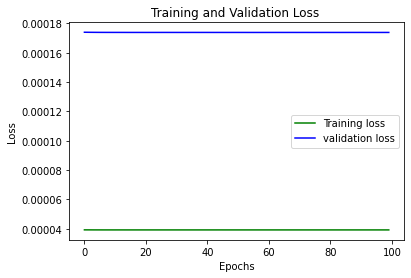

Train Resídual  Valid Resídual  Test Resídual      Train  \
IXIC                                                                          
MSE                      0.000039    1.738965e-04       0.000747   0.000039   
MAPE                     1.077369    5.513595e+09       1.013902   0.011912   
MAE                      0.004458    8.682907e-03       0.018033   0.004458   
RMSE                     0.006257    1.318698e-02       0.027340   0.006257   
POCID                   72.446001    7.410359e+01      73.465347  49.708114   
R2                       0.001201    8.530484e-04      -0.003589   0.999029   
AVR                   4546.898720    1.646531e+03     157.459857   0.000972   
Theil’s U1               0.964330    9.784753e-01       0.984157   0.006564   
Theil’s U2               0.487822    4.787444e-01       0.399591   0.997618   
Evaluate Function        0.015924    1.344015e-08       0.459520  24.723755   

                       Valid       Test  
IXIC                                     
MSE                 0.000174   0.000747  
MAPE                0.007448   0.011835  
MAE                 0.008683   0.018033  
RMSE                0.013187   0.027340  
POCID              47.211155  48.514851  
R2                  0.989612   0.990951  
AVR                 0.010304   0.009117  
Theil’s U1          0.005719   0.008646  
Theil’s U2          0.997804   0.996778  
Evaluate Function  23.421365  24.035373

In [151]:
visualize_loss(lstm.history, "Training and Validation Loss ") 
# MLP.pap()
# visualize_loss(lstm.history, "Training and Validation Loss PAP") 
lstm.pred()
lstm.Save_Evaluate()

Epoch 1/100
14/14 [==============================] - 20s 1s/step - loss: 3.9246e-05 - val_loss: 1.7430e-04
Epoch 2/100
14/14 [==============================] - 20s 1s/step - loss: 3.9236e-05 - val_loss: 1.7428e-04
Epoch 3/100
14/14 [==============================] - 19s 1s/step - loss: 3.9229e-05 - val_loss: 1.7427e-04
Epoch 4/100
14/14 [==============================] - 19s 1s/step - loss: 3.9225e-05 - val_loss: 1.7425e-04
Epoch 5/100
14/14 [==============================] - 19s 1s/step - loss: 3.9220e-05 - val_loss: 1.7423e-04
Epoch 6/100
14/14 [==============================] - 19s 1s/step - loss: 3.9216e-05 - val_loss: 1.7422e-04
Epoch 7/100
14/14 [==============================] - 20s 1s/step - loss: 3.9213e-05 - val_loss: 1.7421e-04
Epoch 8/100
14/14 [==============================] - 19s 1s/step - loss: 3.9214e-05 - val_loss: 1.7420e-04
Epoch 9/100
14/14 [==============================] - 19s 1s/step - loss: 3.9211e-05 - val_loss: 1.7420e-04
Epoch 10/100
14/14 [=================

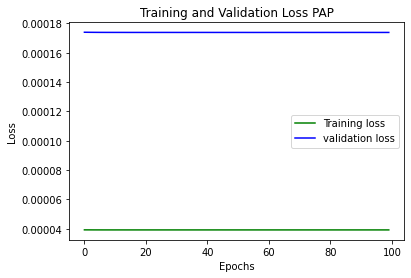

Train Resídual  Valid Resídual  Test Resídual      Train  \
IXIC                                                                          
MSE                      0.000039    1.738965e-04       0.000747   0.000039   
MAPE                     1.077369    5.513595e+09       1.013902   0.011912   
MAE                      0.004458    8.682907e-03       0.018033   0.004458   
RMSE                     0.006257    1.318698e-02       0.027340   0.006257   
POCID                   72.446001    7.410359e+01      73.465347  49.708114   
R2                       0.001201    8.530484e-04      -0.003589   0.999029   
AVR                   4546.898720    1.646531e+03     157.459857   0.000972   
Theil’s U1               0.964330    9.784753e-01       0.984157   0.006564   
Theil’s U2               0.487822    4.787444e-01       0.399591   0.997618   
Evaluate Function        0.015924    1.344015e-08       0.459520  24.723755   

                       Valid       Test  
IXIC                                     
MSE                 0.000174   0.000747  
MAPE                0.007448   0.011835  
MAE                 0.008683   0.018033  
RMSE                0.013187   0.027340  
POCID              47.211155  48.514851  
R2                  0.989612   0.990951  
AVR                 0.010304   0.009117  
Theil’s U1          0.005719   0.008646  
Theil’s U2          0.997804   0.996778  
Evaluate Function  23.421365  24.035373

In [154]:
MLP.pap()
visualize_loss(lstm.history, "Training and Validation Loss PAP") 
lstm.pred()
lstm.Save_Evaluate()

In [ ]:
from bokeh.plotting import figure, show
import pandas as pd
p = figure(title="IMM {}".format(indice), x_axis_label='Retardos Temporais', y_axis_label='IMM')
p.line(Data["Unnamed: 0"] ,Data["0"] , legend_label="Temp.", line_width=1)
show(p)

In [ ]:
GDAXI[0] #Train

1          2          3          4          5       Mean  \
MSE     0.000016   0.000027   0.000071   0.000009   0.000031   0.000031   
MAE     0.003167   0.004183   0.006735   0.002400   0.004795   0.004256   
RMSE    0.003971   0.005223   0.008422   0.002956   0.005574   0.005229   
POCID  67.105263  60.526316  36.842105  72.368421  71.052632  61.578947   
R2      0.925646   0.871336   0.665519   0.958805   0.853487   0.854959   
U1      0.009814   0.012869   0.020861   0.007241   0.013830   0.012923   
U2      1.010829   2.428960   3.823821   0.924250   1.399849   1.917542   

             Std  
MSE     0.000024  
MAE     0.001664  
RMSE    0.002066  
POCID  14.575004  
R2      0.113950  
U1      0.005142  
U2      1.221905

In [ ]:
GDAXI[1] #Valid

1          2          3          4          5       Mean  \
MSE     0.000018   0.000034   0.000051   0.000024   0.000016   0.000029   
MAE     0.003257   0.004624   0.005429   0.004000   0.003186   0.004099   
RMSE    0.004288   0.005854   0.007131   0.004870   0.003986   0.005226   
POCID  46.341463  53.658537  48.780488  58.536585  43.902439  50.243902   
R2      0.880139   0.776622   0.668584   0.845403   0.896429   0.813435   
U1      0.011266   0.015254   0.018602   0.012704   0.010480   0.013661   
U2      1.338352   3.355678   4.113834   1.731446   1.379694   2.383801   

            Std  
MSE    0.000014  
MAE    0.000948  
RMSE   0.001281  
POCID  5.873949  
R2     0.093135  
U1     0.003306  
U2     1.271252

In [ ]:
GDAXI[2] #Test

1          2          3          4          5       Mean  \
MSE     0.000033   0.000062   0.000080   0.000040   0.000035   0.000050   
MAE     0.004700   0.006407   0.007332   0.005556   0.004493   0.005697   
RMSE    0.005766   0.007850   0.008925   0.006345   0.005891   0.006955   
POCID  50.000000  55.263158  42.105263  60.526316  50.000000  51.578947   
R2      0.838122   0.699981   0.612203   0.804002   0.831023   0.757066   
U1      0.015098   0.020358   0.023179   0.016500   0.015418   0.018111   
U2      1.236552   3.247138   3.564509   1.833149   1.428331   2.261936   

            Std  
MSE    0.000020  
MAE    0.001187  
RMSE   0.001378  
POCID  6.862318  
R2     0.098090  
U1     0.003523  
U2     1.072087

: 

In [ ]:
def loop_model():
    results= []
    for serie in Indices:        
        data_eval_train = pd.DataFrame(index=["MSE", "MAE", "RMSE", "POCID", "R2", "U1", "U2"])
        data_eval_valid = pd.DataFrame(index=["MSE", "MAE", "RMSE", "POCID", "R2", "U1", "U2"])
        data_eval_test =  pd.DataFrame(index=["MSE", "MAE", "RMSE", "POCID", "R2", "U1", "U2"])
        
        for e in range(1,6):      
            MLP = MLP_Class(Indice=serie, epochs=150, model_type = "MLP", year= None,  batch_size= None)      
            MLP.fit()
            MLP.pred()
            MLP.Save_Evaluate()
            visualize_loss(MLP.history, "Training and Validation Loss")  
            
            data_eval_train[str(e)] = np.array(MLP.eval_train)
            data_eval_valid[str(e)] = np.array(MLP.eval_valid)
            data_eval_test[str(e)] = np.array(MLP.eval_test)

        data_eval_train["Mean"], data_eval_train["Std"] = data_eval_train.mean(axis=1), data_eval_train.std(axis=1)
        data_eval_valid["Mean"], data_eval_valid["Std"] = data_eval_valid.mean(axis=1), data_eval_valid.std(axis=1)
        data_eval_test["Mean"], data_eval_test["Std"] = data_eval_test.mean(axis=1), data_eval_test.std(axis=1)
        results.append([data_eval_train, data_eval_valid, data_eval_test])
        print("Finished: ", serie)
        
    return results           
results =  loop_model()

In [ ]:
train, valid, test = results[5]

## Results


('2000-01-01', '2016-12-31')
Epoch 1/10
113/115 [============================>.] - ETA: 0s - loss: 87.3647 
Epoch 1: val_loss improved from inf to 0.00548, saving model to best_model.h5
115/115 [==============================] - 1s 5ms/step - loss: 85.8456 - val_loss: 0.0055
Epoch 2/10
109/115 [===========================>..] - ETA: 0s - loss: 0.0069
Epoch 2: val_loss improved from 0.00548 to 0.00322, saving model to best_model.h5
115/115 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0032
Epoch 3/10
110/115 [===========================>..] - ETA: 0s - loss: 0.0025
Epoch 3: val_loss improved from 0.00322 to 0.00255, saving model to best_model.h5
115/115 [==============================] - 0s 4ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 4/10
100/115 [=========================>....] - ETA: 0s - loss: 0.0015
Epoch 4: val_loss improved from 0.00255 to 0.00187, saving model to best_model.h5
115/115 [==============================] - 0s 4ms/step - loss: 0.0014

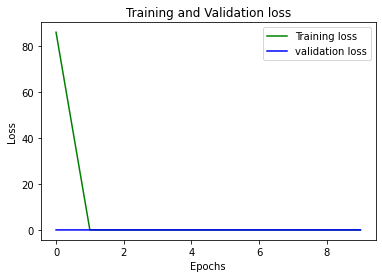

In [ ]:
MLP = MLP_Class(Indice="IXIC", epochs=10, model_type = "MLP", year= None,  batch_size= None)
MLP.fit()
MLP.pred()
MLP.Save_Evaluate()
visualize_loss(MLP.history, "Training and Validation Loss")  

MLP.eval_train
MLP.eval_valid
MLP.eval_test

data_eval_train = pd.DataFrame(index=["MSE", "MAE", "RMSE", "POCID", "R2", "U1", "U2"])
data_eval_valid = pd.DataFrame(index=["MSE", "MAE", "RMSE", "POCID", "R2", "U1", "U2"])
data_eval_test =  pd.DataFrame(index=["MSE", "MAE", "RMSE", "POCID", "R2", "U1", "U2"])

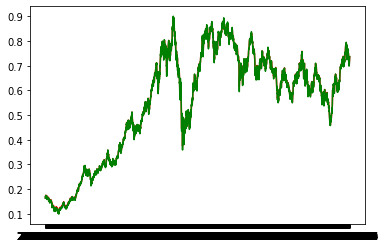

In [ ]:
plt.plot(MLP.pred_train, 'r')
plt.plot(MLP.target_train, 'g')

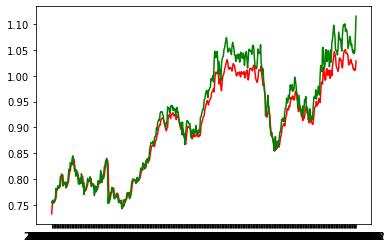

In [ ]:
plt.plot(MLP.pred_valid, 'r')
plt.plot(MLP.target_valid, 'g')